In [1]:
# !pip3 install pyarrow
# !pip3 install lightgbm
# !pip3 install optuna

In [2]:
import pandas as pd
import lightgbm as lgbm
from sklearn.metrics import mean_squared_error, r2_score
from IPython.display import display

In [3]:
def preprocess(df, year):
    df[['Env', 'Hybrid']] = df['id'].str.split(':', expand=True)
    df['Env'] += "_" + str(year)
    df = df.drop('id', axis=1).set_index(['Env', 'Hybrid'])
    return df

In [4]:
%%time

ytrain = pd.read_csv('../output/ytrain.csv').set_index(['Env', 'Hybrid'])
xtrain = pd.read_parquet('../output/kronecker_epi_DD_train.parquet')
xtrain = preprocess(xtrain, year=2020)
xtrain = xtrain.merge(ytrain, on=['Env', 'Hybrid'], how='inner')
ytrain = xtrain['Yield_Mg_ha']
del xtrain['Yield_Mg_ha']

yval = pd.read_csv('../output/yval.csv').set_index(['Env', 'Hybrid'])
xval = pd.read_parquet('../output/kronecker_epi_DD_val.parquet')
xval = preprocess(xval, year=2021)
xval = xval.merge(yval, on=['Env', 'Hybrid'], how='inner')
yval = xval['Yield_Mg_ha']
del xval['Yield_Mg_ha']

CPU times: user 14min 48s, sys: 3min 5s, total: 17min 54s
Wall time: 18min 3s


In [5]:
xtrain

weather_station_lat.2369.DK3IIH6  \
Env       Hybrid                                                
DEH1_2020 B14A/H95                                   0.000066   
          B14A/MO17                                  0.019086   
          B14A/OH43                                  0.006919   
          B37/H95                                    0.037608   
          B37/MO17                                   0.066114   
...                                                       ...   
WIH3_2020 W10004_1123/PHP02                          0.102522   
          W10004_1140/PHP02                          0.152754   
          W10004_1143/PHP02                          0.049357   
          W10004_1146/PHP02                          0.319984   
          W10004_1156/PHP02                          0.307950   

                             weather_station_lat.2369.PHN82  \
Env       Hybrid                                              
DEH1_2020 B14A/H95                                 0.001501   
          B14A/MO17                                0.027402   
          B14A/OH43                                0.002716   
          B37/H95                                  0.054923   
          B37/MO17                                 0.050840   
...                                                     ...   
WIH3_2020 W10004_1123/PHP02                        0.191140   
          W10004_1140/PHP02                        0.384603   
          W10004_1143/PHP02                        0.036129   
          W10004_1146/PHP02                        0.788487   
          W10004_1156/PHP02                        0.573545   

                             weather_station_lat.2369.PHZ51  \
Env       Hybrid                                              
DEH1_2020 B14A/H95                                 0.012171   
          B14A/MO17                                0.111940   
          B14A/OH43                                0.012258   
          B37/H95                                  0.036838   
          B37/MO17                                 0.064654   
...                                                     ...   
WIH3_2020 W10004_1123/PHP02                        0.023652   
          W10004_1140/PHP02                        0.085095   
          W10004_1143/PHP02                        0.071117   
          W10004_1146/PHP02                        0.067091   
          W10004_1156/PHP02                        0.106272   

                             weather_station_lat.2FACC.DK3IIH6  \
Env       Hybrid                                                 
DEH1_2020 B14A/H95                                    0.002416   
          B14A/MO17                                   0.001855   
          B14A/OH43                                   0.000009   
          B37/H95                                     0.004375   
          B37/MO17                                    0.019343   
...                                                        ...   
WIH3_2020 W10004_1123/PHP02                           0.000061   
          W10004_1140/PHP02                           0.004083   
          W10004_1143/PHP02                           0.100550   
          W10004_1146/PHP02                           0.014238   
          W10004_1156/PHP02                           0.024463   

                             weather_station_lat.4N506.DK3IIH6  \
Env       Hybrid                                                 
DEH1_2020 B14A/H95                                    0.002644   
          B14A/MO17                                   0.014349   
          B14A/OH43                                   0.012784   
          B37/H95                                     0.013699   
          B37/MO17                                    0.045999   
...                                                        ...   
WIH3_2020 W10004_1123/PHP02                           0.051705   
          W10004_1140/PHP02                           0.127558   
          W10004_1143/PH

### Training

In [6]:
# %%time

# NCOLS = xtrain.shape[1]
# print('features:', NCOLS)

# best_params = {'feature_fraction': 0.4953070809776986, 'num_leaves': 247, 
#                'bagging_fraction': 0.9866458243098336, 'lambda_l1': 3.680660098838679, 
#                'lambda_l2': 1.1632141265265e-06, 'n_estimators': 232, 'max_depth': 3}
# model = lgbm.LGBMRegressor(random_state=42, **best_params)
# model.fit(xtrain.iloc[:, :NCOLS], ytrain)

# # predict
# ypred = model.predict(xval.iloc[:, :NCOLS])

# # validate
# df_eval = pd.DataFrame()
# df_eval['Env'] = xval.index.get_level_values(0)
# df_eval['ytrue'] = list(yval)
# df_eval['ypred'] = ypred
# rmse_per_group = df_eval.groupby('Env').apply(lambda x: mean_squared_error(x['ytrue'], x['ypred'], squared=False))
# print(rmse_per_group)

# rmse = sum(rmse_per_group) / len(rmse_per_group)
# print('RMSE:', rmse)

In [7]:
# print(r2_score(df_eval['ytrue'], df_eval['ypred']))
# df_eval.plot.scatter('ytrue', 'ypred', figsize=(6, 6));

In [8]:
from sklearn.decomposition import TruncatedSVD

In [31]:
%%time

n_components = 500
svd = TruncatedSVD(n_components=n_components, random_state=42)
svd.fit(xtrain)
print(svd.explained_variance_ratio_.sum())

0.8192256649193372
CPU times: user 18min 40s, sys: 14.1 s, total: 18min 54s
Wall time: 18min 58s


In [32]:
%%time

xtrain_svd = pd.DataFrame(svd.transform(xtrain), index=xtrain.index)
xtrain_svd.columns = [f'kron_svd{i}' for i in range(n_components)]

xval_svd = pd.DataFrame(svd.transform(xval), index=xval.index)
xval_svd.columns = [f'kron_svd{i}' for i in range(n_components)]

CPU times: user 2min 59s, sys: 8.86 ms, total: 2min 59s
Wall time: 3min


In [33]:
xtrain_lag = pd.read_csv('../output/xtrain.csv', usecols=lambda x: 'yield_lag' in x or x in ['Env', 'Hybrid']).set_index(['Env', 'Hybrid'])
xval_lag = pd.read_csv('../output/xval.csv', usecols=lambda x: 'yield_lag' in x or x in ['Env', 'Hybrid']).set_index(['Env', 'Hybrid'])
xtrain_svd = xtrain_svd.merge(xtrain_lag, on=['Env', 'Hybrid'], how='inner')
xval_svd = xval_svd.merge(xval_lag, on=['Env', 'Hybrid'], how='inner')

In [34]:
xtrain_svd

kron_svd0    kron_svd1   kron_svd2   kron_svd3  \
Env       Hybrid                                                               
DEH1_2020 B14A/H95            31.062005    11.519208   24.925608    8.536405   
          B14A/MO17          148.315943    38.944967   93.175006   46.752351   
          B14A/OH43           55.335939    27.858750   75.332532   12.356843   
          B37/H95             77.142166    54.118841   50.280988   21.891793   
          B37/MO17           271.799827   103.787376  138.474896   70.255232   
...                                 ...          ...         ...         ...   
WIH3_2020 W10004_1123/PHP02  237.474437  1403.132216 -177.749785  -84.387525   
          W10004_1140/PHP02  548.577009  2303.099765 -261.912540 -143.700342   
          W10004_1143/PHP02  426.371092  1785.898928 -203.605479 -110.482701   
          W10004_1146/PHP02  543.728034  2562.667281 -302.400722 -157.575643   
          W10004_1156/PHP02  380.379157  1564.464278 -186.541368 -102.356569   

                             kron_svd4    kron_svd5   kron_svd6   kron_svd7  \
Env       Hybrid                                                              
DEH1_2020 B14A/H95           11.895186    57.473938    0.674779    3.084213   
          B14A/MO17          78.224297   180.980091  -12.820731   -9.061439   
          B14A/OH43          19.026774    84.435580   -1.851921    4.352019   
          B37/H95            39.158020   133.055443   -8.167243    7.540720   
          B37/MO17           52.863758   320.731352   39.405834  -14.344401   
...                                ...          ...         ...         ...   
WIH3_2020 W10004_1123/PHP02 -59.323886 -1013.244686  217.682401 -192.498540   
          W10004_1140/PHP02  61.472955   307.487639  -25.779047   16.386156   
          W10004_1143/PHP02  56.037537   165.575212  -59.542245   16.598932   
          W10004_1146/PHP02  -1.284683  -304.091562  110.590192  -29.904510   
          W10004_1156/PHP02  39.809947  -192.854943   84.351118  -33.492003   

                               kron_svd8   kron_svd9  ...  kron_svd496  \
Env       Hybrid                                      ...                
DEH1_2020 B14A/H95             37.613658   -2.899462  ...   -10.631505   
          B14A/MO17           176.060961  -14.517423  ...    14.309485   
          B14A/OH43            52.521669   -4.044724  ...    -7.953957   
          B37/H95              43.932385   -3.315137  ...    18.072062   
          B37/MO17            183.263269  -15.499910  ...    12.742887   
...                                  ...         ...  ...          ...   
WIH3_2020 W10004_1123/PHP02  1808.161491  269.721373  ...   127.473764   
          W10004_1140/PHP02   117.000646  805.751021  ...    96.751344   
          W10004_1143/PHP02  -320.939740  679.062925  ...   -90.347569   
          W10004_1146/PHP02   245.997515  894.978622  ...  -123.775786   
          W10004_1156/PHP02   325.643174  535.028922  ...   -86.310013   

                             kron_svd497  kron_svd498  kron_svd499  \
Env       Hybrid                                                     
DEH1_2020 B14A/H95             -2.643726    -4.159507    -1.316196   
          B14A/MO17            12.817731    10.703952     7.822974   
          B14A/OH43            -1.648535    -3.656967    -0.325722   
          B37/H95              21.807978    -5.865823   -11.445374   
          B37/MO17              9.486140   -10.932046    -9.590945   
...                                  ...          ...          ...   
WIH3_2020 W10004_1123/PHP02  -105.806845    54.175214   160.232472   
          W10004_1140/PHP02  -137.584279   201.710158   187.768549   
          W10004_1143/PHP02    46.805518   152.677390   -82.865706   
          W10004_1146/PHP02   -30.873204   -82.421683   -73.508551   
          W10004_1156/PHP02   -89.147532   -11.277675     3.321518   

                             mean_yield_lag_2  min_yield_lag_2  \
Env       Hybrid     

In [35]:
import optuna

In [36]:
def objective(trial):
    """
    https://medium.com/optuna/lightgbm-tuner-new-optuna-integration-for-hyperparameter-optimization-8b7095e99258
    """
    params = {

#         'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
#         'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.0, 1.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
#         'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'n_estimators': trial.suggest_int('n_estimators', 10, 300),
        'max_depth': trial.suggest_int('max_depth', 2, 6),
        'deterministic': True,
        'random_state': 42
    }
    
    model2 = lgbm.LGBMRegressor(**params)
    model2.fit(xtrain_svd, ytrain)

    # predict
    ypred2 = model2.predict(xval_svd)

    # validate
    df_eval2 = pd.DataFrame()
    df_eval2['Env'] = xval_svd.index.get_level_values(0)
    df_eval2['ytrue'] = list(yval)
    df_eval2['ypred'] = ypred2
    rmse_per_group2 = df_eval2.groupby('Env').apply(lambda x: mean_squared_error(x['ytrue'], x['ypred'], squared=False))
    # print(rmse_per_group2)

    rmse2 = sum(rmse_per_group2) / len(rmse_per_group2)
    return rmse2


study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=200)
 
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Best RMSE:', study.best_value)

[I 2023-02-01 18:09:59,772] A new study created in memory with name: no-name-7eee89dd-036f-4e28-a7f8-524034e80fec


[LightGBM] [Warning] lambda_l1 is set=0.0024430162614261413, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0024430162614261413
[LightGBM] [Warning] bagging_fraction is set=0.839196365086843, subsample=1.0 will be ignored. Current value: bagging_fraction=0.839196365086843
[LightGBM] [Warning] feature_fraction is set=0.3745401188473625, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3745401188473625
[LightGBM] [Warning] lambda_l2 is set=2.5361081166471375e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5361081166471375e-07


[I 2023-02-01 18:10:01,394] Trial 0 finished with value: 2.283029810739097 and parameters: {'feature_fraction': 0.3745401188473625, 'num_leaves': 244, 'bagging_fraction': 0.839196365086843, 'lambda_l1': 0.0024430162614261413, 'lambda_l2': 2.5361081166471375e-07, 'n_estimators': 55, 'max_depth': 2}. Best is trial 0 with value: 2.283029810739097.


[LightGBM] [Warning] lambda_l1 is set=1.5320059381854043e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5320059381854043e-08
[LightGBM] [Warning] bagging_fraction is set=0.8248435466776274, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8248435466776274
[LightGBM] [Warning] feature_fraction is set=0.8661761457749352, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8661761457749352
[LightGBM] [Warning] lambda_l2 is set=5.360294728728285, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.360294728728285


[I 2023-02-01 18:10:07,304] Trial 1 finished with value: 2.2340052209292605 and parameters: {'feature_fraction': 0.8661761457749352, 'num_leaves': 155, 'bagging_fraction': 0.8248435466776274, 'lambda_l1': 1.5320059381854043e-08, 'lambda_l2': 5.360294728728285, 'n_estimators': 252, 'max_depth': 3}. Best is trial 1 with value: 2.2340052209292605.


[LightGBM] [Warning] lambda_l1 is set=0.00052821153945323, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00052821153945323
[LightGBM] [Warning] bagging_fraction is set=0.5825453457757226, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5825453457757226
[LightGBM] [Warning] feature_fraction is set=0.18182496720710062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18182496720710062
[LightGBM] [Warning] lambda_l2 is set=7.71800699380605e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.71800699380605e-05


[I 2023-02-01 18:10:09,644] Trial 2 finished with value: 2.2862502530385336 and parameters: {'feature_fraction': 0.18182496720710062, 'num_leaves': 48, 'bagging_fraction': 0.5825453457757226, 'lambda_l1': 0.00052821153945323, 'lambda_l2': 7.71800699380605e-05, 'n_estimators': 94, 'max_depth': 5}. Best is trial 1 with value: 2.2340052209292605.


[LightGBM] [Warning] lambda_l1 is set=0.00012724181576752517, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00012724181576752517
[LightGBM] [Warning] bagging_fraction is set=0.619817105976215, subsample=1.0 will be ignored. Current value: bagging_fraction=0.619817105976215
[LightGBM] [Warning] feature_fraction is set=0.13949386065204183, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13949386065204183
[LightGBM] [Warning] lambda_l2 is set=0.1165691561324743, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1165691561324743


[I 2023-02-01 18:10:11,332] Trial 3 finished with value: 2.291888046614327 and parameters: {'feature_fraction': 0.13949386065204183, 'num_leaves': 76, 'bagging_fraction': 0.619817105976215, 'lambda_l1': 0.00012724181576752517, 'lambda_l2': 0.1165691561324743, 'n_estimators': 68, 'max_depth': 4}. Best is trial 1 with value: 2.2340052209292605.


[LightGBM] [Warning] lambda_l1 is set=3.425445902633376e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.425445902633376e-07
[LightGBM] [Warning] bagging_fraction is set=0.764526911140863, subsample=1.0 will be ignored. Current value: bagging_fraction=0.764526911140863
[LightGBM] [Warning] feature_fraction is set=0.5924145688620425, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5924145688620425
[LightGBM] [Warning] lambda_l2 is set=3.850031979199519e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.850031979199519e-08


[I 2023-02-01 18:10:19,163] Trial 4 finished with value: 2.3185772808061595 and parameters: {'feature_fraction': 0.5924145688620425, 'num_leaves': 13, 'bagging_fraction': 0.764526911140863, 'lambda_l1': 3.425445902633376e-07, 'lambda_l2': 3.850031979199519e-08, 'n_estimators': 286, 'max_depth': 6}. Best is trial 1 with value: 2.2340052209292605.


[LightGBM] [Warning] lambda_l1 is set=0.014391207615728067, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.014391207615728067
[LightGBM] [Warning] bagging_fraction is set=0.45860326840383037, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45860326840383037
[LightGBM] [Warning] feature_fraction is set=0.8083973481164611, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8083973481164611
[LightGBM] [Warning] lambda_l2 is set=9.148975058772307e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.148975058772307e-05


[I 2023-02-01 18:10:21,807] Trial 5 finished with value: 2.3852410701656006 and parameters: {'feature_fraction': 0.8083973481164611, 'num_leaves': 79, 'bagging_fraction': 0.45860326840383037, 'lambda_l1': 0.014391207615728067, 'lambda_l2': 9.148975058772307e-05, 'n_estimators': 45, 'max_depth': 4}. Best is trial 1 with value: 2.2340052209292605.


[LightGBM] [Warning] lambda_l1 is set=0.009176996354542699, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009176996354542699
[LightGBM] [Warning] bagging_fraction is set=0.5552679889600102, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5552679889600102
[LightGBM] [Warning] feature_fraction is set=0.034388521115218396, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.034388521115218396
[LightGBM] [Warning] lambda_l2 is set=6.388511557344611e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.388511557344611e-06


[I 2023-02-01 18:10:23,437] Trial 6 finished with value: 2.185984572474408 and parameters: {'feature_fraction': 0.034388521115218396, 'num_leaves': 233, 'bagging_fraction': 0.5552679889600102, 'lambda_l1': 0.009176996354542699, 'lambda_l2': 6.388511557344611e-06, 'n_estimators': 161, 'max_depth': 4}. Best is trial 6 with value: 2.185984572474408.


[LightGBM] [Warning] lambda_l1 is set=2.854239907497756, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.854239907497756
[LightGBM] [Warning] bagging_fraction is set=0.8650796940166687, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8650796940166687
[LightGBM] [Warning] feature_fraction is set=0.18485445552552704, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18485445552552704
[LightGBM] [Warning] lambda_l2 is set=1.1309571585271483, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1309571585271483


[I 2023-02-01 18:10:27,870] Trial 7 finished with value: 2.3368517012363483 and parameters: {'feature_fraction': 0.18485445552552704, 'num_leaves': 249, 'bagging_fraction': 0.8650796940166687, 'lambda_l1': 2.854239907497756, 'lambda_l2': 1.1309571585271483, 'n_estimators': 183, 'max_depth': 6}. Best is trial 6 with value: 2.185984572474408.


[LightGBM] [Warning] lambda_l1 is set=8.471746987003668e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.471746987003668e-06
[LightGBM] [Warning] bagging_fraction is set=0.4271363733463229, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4271363733463229
[LightGBM] [Warning] feature_fraction is set=0.0884925020519195, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.0884925020519195
[LightGBM] [Warning] lambda_l2 is set=3.148441347423712e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.148441347423712e-05


[I 2023-02-01 18:10:29,943] Trial 8 finished with value: 2.2463839945317874 and parameters: {'feature_fraction': 0.0884925020519195, 'num_leaves': 51, 'bagging_fraction': 0.4271363733463229, 'lambda_l1': 8.471746987003668e-06, 'lambda_l2': 3.148441347423712e-05, 'n_estimators': 88, 'max_depth': 6}. Best is trial 6 with value: 2.185984572474408.


[LightGBM] [Warning] lambda_l1 is set=1.8548894229694903e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8548894229694903e-07
[LightGBM] [Warning] bagging_fraction is set=0.7256176498949491, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7256176498949491
[LightGBM] [Warning] feature_fraction is set=0.3567533266935893, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3567533266935893
[LightGBM] [Warning] lambda_l2 is set=0.16587190283399655, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.16587190283399655


[I 2023-02-01 18:10:32,355] Trial 9 finished with value: 2.2964876022140492 and parameters: {'feature_fraction': 0.3567533266935893, 'num_leaves': 73, 'bagging_fraction': 0.7256176498949491, 'lambda_l1': 1.8548894229694903e-07, 'lambda_l2': 0.16587190283399655, 'n_estimators': 31, 'max_depth': 6}. Best is trial 6 with value: 2.185984572474408.


[LightGBM] [Warning] lambda_l1 is set=0.19237494135966834, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19237494135966834
[LightGBM] [Warning] bagging_fraction is set=0.9817222664727197, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9817222664727197
[LightGBM] [Warning] feature_fraction is set=0.02051392850324301, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.02051392850324301
[LightGBM] [Warning] lambda_l2 is set=6.739006603244534e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.739006603244534e-07


[I 2023-02-01 18:10:33,873] Trial 10 finished with value: 2.210064596787756 and parameters: {'feature_fraction': 0.02051392850324301, 'num_leaves': 182, 'bagging_fraction': 0.9817222664727197, 'lambda_l1': 0.19237494135966834, 'lambda_l2': 6.739006603244534e-07, 'n_estimators': 167, 'max_depth': 3}. Best is trial 6 with value: 2.185984572474408.


[LightGBM] [Warning] lambda_l1 is set=0.11731504557993938, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.11731504557993938
[LightGBM] [Warning] bagging_fraction is set=0.997479579295848, subsample=1.0 will be ignored. Current value: bagging_fraction=0.997479579295848
[LightGBM] [Warning] feature_fraction is set=0.0108757259358968, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.0108757259358968
[LightGBM] [Warning] lambda_l2 is set=8.956408095934925e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.956408095934925e-07


[I 2023-02-01 18:10:35,358] Trial 11 finished with value: 2.316168477858715 and parameters: {'feature_fraction': 0.0108757259358968, 'num_leaves': 185, 'bagging_fraction': 0.997479579295848, 'lambda_l1': 0.11731504557993938, 'lambda_l2': 8.956408095934925e-07, 'n_estimators': 166, 'max_depth': 3}. Best is trial 6 with value: 2.185984572474408.


[LightGBM] [Warning] lambda_l1 is set=0.23641781747396198, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.23641781747396198
[LightGBM] [Warning] bagging_fraction is set=0.9945707878065353, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9945707878065353
[LightGBM] [Warning] feature_fraction is set=0.017321165717232034, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.017321165717232034
[LightGBM] [Warning] lambda_l2 is set=2.528830125346676e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.528830125346676e-06


[I 2023-02-01 18:10:36,914] Trial 12 finished with value: 2.301709787355232 and parameters: {'feature_fraction': 0.017321165717232034, 'num_leaves': 201, 'bagging_fraction': 0.9945707878065353, 'lambda_l1': 0.23641781747396198, 'lambda_l2': 2.528830125346676e-06, 'n_estimators': 204, 'max_depth': 3}. Best is trial 6 with value: 2.185984572474408.


[LightGBM] [Warning] lambda_l1 is set=7.0557555476473155, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.0557555476473155
[LightGBM] [Warning] bagging_fraction is set=0.6264965712313106, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6264965712313106
[LightGBM] [Warning] feature_fraction is set=0.24080793750091012, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24080793750091012
[LightGBM] [Warning] lambda_l2 is set=2.005732281713045e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.005732281713045e-08


[I 2023-02-01 18:10:38,717] Trial 13 finished with value: 2.2180390775056793 and parameters: {'feature_fraction': 0.24080793750091012, 'num_leaves': 205, 'bagging_fraction': 0.6264965712313106, 'lambda_l1': 7.0557555476473155, 'lambda_l2': 2.005732281713045e-08, 'n_estimators': 129, 'max_depth': 2}. Best is trial 6 with value: 2.185984572474408.


[LightGBM] [Warning] lambda_l1 is set=0.030465573763507302, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.030465573763507302
[LightGBM] [Warning] bagging_fraction is set=0.5501279035873242, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5501279035873242
[LightGBM] [Warning] feature_fraction is set=0.3082829246820051, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3082829246820051
[LightGBM] [Warning] lambda_l2 is set=0.0020762047805725683, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0020762047805725683


[I 2023-02-01 18:10:43,620] Trial 14 finished with value: 2.3069276822565463 and parameters: {'feature_fraction': 0.3082829246820051, 'num_leaves': 133, 'bagging_fraction': 0.5501279035873242, 'lambda_l1': 0.030465573763507302, 'lambda_l2': 0.0020762047805725683, 'n_estimators': 208, 'max_depth': 5}. Best is trial 6 with value: 2.185984572474408.


[LightGBM] [Warning] lambda_l1 is set=0.48655210851246833, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.48655210851246833
[LightGBM] [Warning] bagging_fraction is set=0.6854856055112454, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6854856055112454
[LightGBM] [Warning] feature_fraction is set=0.019309651780764506, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.019309651780764506
[LightGBM] [Warning] lambda_l2 is set=4.733285371660662e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.733285371660662e-06


[I 2023-02-01 18:10:45,165] Trial 15 finished with value: 2.1946517830314063 and parameters: {'feature_fraction': 0.019309651780764506, 'num_leaves': 166, 'bagging_fraction': 0.6854856055112454, 'lambda_l1': 0.48655210851246833, 'lambda_l2': 4.733285371660662e-06, 'n_estimators': 130, 'max_depth': 4}. Best is trial 6 with value: 2.185984572474408.


[LightGBM] [Warning] lambda_l1 is set=0.004928442672028538, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004928442672028538
[LightGBM] [Warning] bagging_fraction is set=0.671395787726565, subsample=1.0 will be ignored. Current value: bagging_fraction=0.671395787726565
[LightGBM] [Warning] feature_fraction is set=0.4820473222840905, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4820473222840905
[LightGBM] [Warning] lambda_l2 is set=1.2820466417378132e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2820466417378132e-05


[I 2023-02-01 18:10:49,761] Trial 16 finished with value: 2.259840431704728 and parameters: {'feature_fraction': 0.4820473222840905, 'num_leaves': 218, 'bagging_fraction': 0.671395787726565, 'lambda_l1': 0.004928442672028538, 'lambda_l2': 1.2820466417378132e-05, 'n_estimators': 123, 'max_depth': 5}. Best is trial 6 with value: 2.185984572474408.


[LightGBM] [Warning] lambda_l1 is set=0.9558057619128076, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9558057619128076
[LightGBM] [Warning] bagging_fraction is set=0.5284161801248887, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5284161801248887
[LightGBM] [Warning] feature_fraction is set=0.10345880604163472, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10345880604163472
[LightGBM] [Warning] lambda_l2 is set=0.0010797510794422597, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010797510794422597


[I 2023-02-01 18:10:51,639] Trial 17 finished with value: 2.233179913103924 and parameters: {'feature_fraction': 0.10345880604163472, 'num_leaves': 141, 'bagging_fraction': 0.5284161801248887, 'lambda_l1': 0.9558057619128076, 'lambda_l2': 0.0010797510794422597, 'n_estimators': 114, 'max_depth': 4}. Best is trial 6 with value: 2.185984572474408.


[LightGBM] [Warning] lambda_l1 is set=0.9771702525675117, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9771702525675117
[LightGBM] [Warning] bagging_fraction is set=0.5022212849190505, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5022212849190505
[LightGBM] [Warning] feature_fraction is set=0.25432836726550717, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25432836726550717
[LightGBM] [Warning] lambda_l2 is set=6.127834359657691e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.127834359657691e-06


[I 2023-02-01 18:10:55,238] Trial 18 finished with value: 2.2645247035680267 and parameters: {'feature_fraction': 0.25432836726550717, 'num_leaves': 105, 'bagging_fraction': 0.5022212849190505, 'lambda_l1': 0.9771702525675117, 'lambda_l2': 6.127834359657691e-06, 'n_estimators': 232, 'max_depth': 4}. Best is trial 6 with value: 2.185984572474408.


[LightGBM] [Warning] lambda_l1 is set=0.040999293322360054, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.040999293322360054
[LightGBM] [Warning] bagging_fraction is set=0.6676870252449375, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6676870252449375
[LightGBM] [Warning] feature_fraction is set=0.10028971186127349, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10028971186127349
[LightGBM] [Warning] lambda_l2 is set=1.2806146614744405e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2806146614744405e-07


[I 2023-02-01 18:10:57,509] Trial 19 finished with value: 2.242967186549896 and parameters: {'feature_fraction': 0.10028971186127349, 'num_leaves': 165, 'bagging_fraction': 0.6676870252449375, 'lambda_l1': 0.040999293322360054, 'lambda_l2': 1.2806146614744405e-07, 'n_estimators': 144, 'max_depth': 5}. Best is trial 6 with value: 2.185984572474408.


[LightGBM] [Warning] lambda_l1 is set=0.003309099524584676, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003309099524584676
[LightGBM] [Warning] bagging_fraction is set=0.47276569567174453, subsample=1.0 will be ignored. Current value: bagging_fraction=0.47276569567174453
[LightGBM] [Warning] feature_fraction is set=0.2511546236069977, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2511546236069977
[LightGBM] [Warning] lambda_l2 is set=4.248382899022941e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.248382899022941e-06


[I 2023-02-01 18:10:58,900] Trial 20 finished with value: 2.4269701598402142 and parameters: {'feature_fraction': 0.2511546236069977, 'num_leaves': 226, 'bagging_fraction': 0.47276569567174453, 'lambda_l1': 0.003309099524584676, 'lambda_l2': 4.248382899022941e-06, 'n_estimators': 10, 'max_depth': 3}. Best is trial 6 with value: 2.185984572474408.


[LightGBM] [Warning] lambda_l1 is set=0.2554011272484672, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2554011272484672
[LightGBM] [Warning] bagging_fraction is set=0.7162893893801279, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7162893893801279
[LightGBM] [Warning] feature_fraction is set=0.015112170706085854, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.015112170706085854
[LightGBM] [Warning] lambda_l2 is set=3.8830182612352955e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.8830182612352955e-07


[I 2023-02-01 18:11:00,402] Trial 21 finished with value: 2.2605881201645235 and parameters: {'feature_fraction': 0.015112170706085854, 'num_leaves': 173, 'bagging_fraction': 0.7162893893801279, 'lambda_l1': 0.2554011272484672, 'lambda_l2': 3.8830182612352955e-07, 'n_estimators': 168, 'max_depth': 3}. Best is trial 6 with value: 2.185984572474408.


[LightGBM] [Warning] lambda_l1 is set=0.11335583274752624, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.11335583274752624
[LightGBM] [Warning] bagging_fraction is set=0.5928426933510111, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5928426933510111
[LightGBM] [Warning] feature_fraction is set=0.027922408888402916, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.027922408888402916
[LightGBM] [Warning] lambda_l2 is set=9.055464432435397e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.055464432435397e-07


[I 2023-02-01 18:11:02,008] Trial 22 finished with value: 2.1962149979611163 and parameters: {'feature_fraction': 0.027922408888402916, 'num_leaves': 190, 'bagging_fraction': 0.5928426933510111, 'lambda_l1': 0.11335583274752624, 'lambda_l2': 9.055464432435397e-07, 'n_estimators': 145, 'max_depth': 4}. Best is trial 6 with value: 2.185984572474408.


[LightGBM] [Warning] lambda_l1 is set=9.52582938946564, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.52582938946564
[LightGBM] [Warning] bagging_fraction is set=0.5689779279954031, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5689779279954031
[LightGBM] [Warning] feature_fraction is set=0.14241065498337135, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14241065498337135
[LightGBM] [Warning] lambda_l2 is set=1.4477928778418136e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4477928778418136e-06


[I 2023-02-01 18:11:04,181] Trial 23 finished with value: 2.27822839042889 and parameters: {'feature_fraction': 0.14241065498337135, 'num_leaves': 230, 'bagging_fraction': 0.5689779279954031, 'lambda_l1': 9.52582938946564, 'lambda_l2': 1.4477928778418136e-06, 'n_estimators': 144, 'max_depth': 4}. Best is trial 6 with value: 2.185984572474408.


[LightGBM] [Warning] lambda_l1 is set=0.02692613111941447, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02692613111941447
[LightGBM] [Warning] bagging_fraction is set=0.6114424806873628, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6114424806873628
[LightGBM] [Warning] feature_fraction is set=0.06320300751036168, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.06320300751036168
[LightGBM] [Warning] lambda_l2 is set=1.720516237193766e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.720516237193766e-05


[I 2023-02-01 18:11:05,973] Trial 24 finished with value: 2.2329987989670355 and parameters: {'feature_fraction': 0.06320300751036168, 'num_leaves': 199, 'bagging_fraction': 0.6114424806873628, 'lambda_l1': 0.02692613111941447, 'lambda_l2': 1.720516237193766e-05, 'n_estimators': 99, 'max_depth': 5}. Best is trial 6 with value: 2.185984572474408.


[LightGBM] [Warning] lambda_l1 is set=1.1244492589264536, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1244492589264536
[LightGBM] [Warning] bagging_fraction is set=0.5125648148170738, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5125648148170738
[LightGBM] [Warning] feature_fraction is set=0.16006210943489052, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16006210943489052
[LightGBM] [Warning] lambda_l2 is set=8.252322859997551e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.252322859997551e-08


[I 2023-02-01 18:11:08,624] Trial 25 finished with value: 2.2470393377466307 and parameters: {'feature_fraction': 0.16006210943489052, 'num_leaves': 118, 'bagging_fraction': 0.5125648148170738, 'lambda_l1': 1.1244492589264536, 'lambda_l2': 8.252322859997551e-08, 'n_estimators': 201, 'max_depth': 4}. Best is trial 6 with value: 2.185984572474408.


[LightGBM] [Warning] lambda_l1 is set=0.06228553680241676, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06228553680241676
[LightGBM] [Warning] bagging_fraction is set=0.5792810002968508, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5792810002968508
[LightGBM] [Warning] feature_fraction is set=0.08471628775706005, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.08471628775706005
[LightGBM] [Warning] lambda_l2 is set=3.151567049842782e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.151567049842782e-06


[I 2023-02-01 18:11:10,489] Trial 26 finished with value: 2.193373747748334 and parameters: {'feature_fraction': 0.08471628775706005, 'num_leaves': 147, 'bagging_fraction': 0.5792810002968508, 'lambda_l1': 0.06228553680241676, 'lambda_l2': 3.151567049842782e-06, 'n_estimators': 139, 'max_depth': 4}. Best is trial 6 with value: 2.185984572474408.


[LightGBM] [Warning] lambda_l1 is set=0.013937709580325716, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013937709580325716
[LightGBM] [Warning] bagging_fraction is set=0.547546689656343, subsample=1.0 will be ignored. Current value: bagging_fraction=0.547546689656343
[LightGBM] [Warning] feature_fraction is set=0.10601387086809581, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10601387086809581
[LightGBM] [Warning] lambda_l2 is set=1.1877957177298207e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1877957177298207e-08


[I 2023-02-01 18:11:13,064] Trial 27 finished with value: 2.267144273039968 and parameters: {'feature_fraction': 0.10601387086809581, 'num_leaves': 146, 'bagging_fraction': 0.547546689656343, 'lambda_l1': 0.013937709580325716, 'lambda_l2': 1.1877957177298207e-08, 'n_estimators': 188, 'max_depth': 5}. Best is trial 6 with value: 2.185984572474408.


[LightGBM] [Warning] lambda_l1 is set=0.0002672719859908737, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002672719859908737
[LightGBM] [Warning] bagging_fraction is set=0.4128673898932509, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4128673898932509
[LightGBM] [Warning] feature_fraction is set=0.21292956743649316, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21292956743649316
[LightGBM] [Warning] lambda_l2 is set=0.00019780094119080854, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019780094119080854


[I 2023-02-01 18:11:16,135] Trial 28 finished with value: 2.2617892374400648 and parameters: {'feature_fraction': 0.21292956743649316, 'num_leaves': 110, 'bagging_fraction': 0.4128673898932509, 'lambda_l1': 0.0002672719859908737, 'lambda_l2': 0.00019780094119080854, 'n_estimators': 226, 'max_depth': 4}. Best is trial 6 with value: 2.185984572474408.


[LightGBM] [Warning] lambda_l1 is set=0.002323164867247539, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002323164867247539
[LightGBM] [Warning] bagging_fraction is set=0.6618399119198247, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6618399119198247
[LightGBM] [Warning] feature_fraction is set=0.3040999172239286, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3040999172239286
[LightGBM] [Warning] lambda_l2 is set=1.2905900902759903e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2905900902759903e-07


[I 2023-02-01 18:11:18,302] Trial 29 finished with value: 2.2577355727343806 and parameters: {'feature_fraction': 0.3040999172239286, 'num_leaves': 251, 'bagging_fraction': 0.6618399119198247, 'lambda_l1': 0.002323164867247539, 'lambda_l2': 1.2905900902759903e-07, 'n_estimators': 74, 'max_depth': 4}. Best is trial 6 with value: 2.185984572474408.


[LightGBM] [Warning] lambda_l1 is set=0.6788716940844829, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6788716940844829
[LightGBM] [Warning] bagging_fraction is set=0.569508278517381, subsample=1.0 will be ignored. Current value: bagging_fraction=0.569508278517381
[LightGBM] [Warning] feature_fraction is set=0.07846330335511344, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.07846330335511344
[LightGBM] [Warning] lambda_l2 is set=6.622065218937442e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.622065218937442e-06


[I 2023-02-01 18:11:19,810] Trial 30 finished with value: 2.244228613691346 and parameters: {'feature_fraction': 0.07846330335511344, 'num_leaves': 163, 'bagging_fraction': 0.569508278517381, 'lambda_l1': 0.6788716940844829, 'lambda_l2': 6.622065218937442e-06, 'n_estimators': 117, 'max_depth': 2}. Best is trial 6 with value: 2.185984572474408.


[LightGBM] [Warning] lambda_l1 is set=0.0652741351474146, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0652741351474146
[LightGBM] [Warning] bagging_fraction is set=0.6055539124370094, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6055539124370094
[LightGBM] [Warning] feature_fraction is set=0.0021975772011636023, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.0021975772011636023
[LightGBM] [Warning] lambda_l2 is set=4.0069438498963983e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.0069438498963983e-07


[I 2023-02-01 18:11:21,286] Trial 31 finished with value: 2.379239460301213 and parameters: {'feature_fraction': 0.0021975772011636023, 'num_leaves': 188, 'bagging_fraction': 0.6055539124370094, 'lambda_l1': 0.0652741351474146, 'lambda_l2': 4.0069438498963983e-07, 'n_estimators': 149, 'max_depth': 4}. Best is trial 6 with value: 2.185984572474408.


[LightGBM] [Warning] lambda_l1 is set=0.08789882113450002, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08789882113450002
[LightGBM] [Warning] bagging_fraction is set=0.6431573905829224, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6431573905829224
[LightGBM] [Warning] feature_fraction is set=0.06665132565774179, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.06665132565774179
[LightGBM] [Warning] lambda_l2 is set=3.104030250056324e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.104030250056324e-06


[I 2023-02-01 18:11:23,052] Trial 32 finished with value: 2.203067119176229 and parameters: {'feature_fraction': 0.06665132565774179, 'num_leaves': 234, 'bagging_fraction': 0.6431573905829224, 'lambda_l1': 0.08789882113450002, 'lambda_l2': 3.104030250056324e-06, 'n_estimators': 136, 'max_depth': 4}. Best is trial 6 with value: 2.185984572474408.


[LightGBM] [Warning] lambda_l1 is set=0.2764250776177965, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2764250776177965
[LightGBM] [Warning] bagging_fraction is set=0.5859897319974459, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5859897319974459
[LightGBM] [Warning] feature_fraction is set=0.16791746793610846, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16791746793610846
[LightGBM] [Warning] lambda_l2 is set=1.449369604446006e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.449369604446006e-06


[I 2023-02-01 18:11:25,481] Trial 33 finished with value: 2.2948503359808003 and parameters: {'feature_fraction': 0.16791746793610846, 'num_leaves': 212, 'bagging_fraction': 0.5859897319974459, 'lambda_l1': 0.2764250776177965, 'lambda_l2': 1.449369604446006e-06, 'n_estimators': 103, 'max_depth': 5}. Best is trial 6 with value: 2.185984572474408.


[LightGBM] [Warning] lambda_l1 is set=0.018073082473312897, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.018073082473312897
[LightGBM] [Warning] bagging_fraction is set=0.5938758909112674, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5938758909112674
[LightGBM] [Warning] feature_fraction is set=0.14422986274682967, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14422986274682967
[LightGBM] [Warning] lambda_l2 is set=3.526103546176815e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.526103546176815e-05


[I 2023-02-01 18:11:27,384] Trial 34 finished with value: 2.2934089781467817 and parameters: {'feature_fraction': 0.14422986274682967, 'num_leaves': 153, 'bagging_fraction': 0.5938758909112674, 'lambda_l1': 0.018073082473312897, 'lambda_l2': 3.526103546176815e-05, 'n_estimators': 157, 'max_depth': 3}. Best is trial 6 with value: 2.185984572474408.


[LightGBM] [Warning] lambda_l1 is set=0.0010401002794065222, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0010401002794065222
[LightGBM] [Warning] bagging_fraction is set=0.540362675205506, subsample=1.0 will be ignored. Current value: bagging_fraction=0.540362675205506
[LightGBM] [Warning] feature_fraction is set=0.04914105150035468, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.04914105150035468
[LightGBM] [Warning] lambda_l2 is set=2.564156217667231e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.564156217667231e-07


[I 2023-02-01 18:11:29,192] Trial 35 finished with value: 2.228608871480907 and parameters: {'feature_fraction': 0.04914105150035468, 'num_leaves': 127, 'bagging_fraction': 0.540362675205506, 'lambda_l1': 0.0010401002794065222, 'lambda_l2': 2.564156217667231e-07, 'n_estimators': 185, 'max_depth': 4}. Best is trial 6 with value: 2.185984572474408.


[LightGBM] [Warning] lambda_l1 is set=0.009537287386690066, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009537287386690066
[LightGBM] [Warning] bagging_fraction is set=0.6397056546533177, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6397056546533177
[LightGBM] [Warning] feature_fraction is set=0.13282144520607542, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13282144520607542
[LightGBM] [Warning] lambda_l2 is set=1.014103493337975e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.014103493337975e-05


[I 2023-02-01 18:11:31,896] Trial 36 finished with value: 2.249390075230704 and parameters: {'feature_fraction': 0.13282144520607542, 'num_leaves': 175, 'bagging_fraction': 0.6397056546533177, 'lambda_l1': 0.009537287386690066, 'lambda_l2': 1.014103493337975e-05, 'n_estimators': 261, 'max_depth': 4}. Best is trial 6 with value: 2.185984572474408.


[LightGBM] [Warning] lambda_l1 is set=0.06824168945889049, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06824168945889049
[LightGBM] [Warning] bagging_fraction is set=0.579680366394544, subsample=1.0 will be ignored. Current value: bagging_fraction=0.579680366394544
[LightGBM] [Warning] feature_fraction is set=0.19714689918112016, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19714689918112016
[LightGBM] [Warning] lambda_l2 is set=8.333346858600149e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.333346858600149e-05


[I 2023-02-01 18:11:34,230] Trial 37 finished with value: 2.290607288240984 and parameters: {'feature_fraction': 0.19714689918112016, 'num_leaves': 98, 'bagging_fraction': 0.579680366394544, 'lambda_l1': 0.06824168945889049, 'lambda_l2': 8.333346858600149e-05, 'n_estimators': 81, 'max_depth': 5}. Best is trial 6 with value: 2.185984572474408.


[LightGBM] [Warning] lambda_l1 is set=2.8686226449745154, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8686226449745154
[LightGBM] [Warning] bagging_fraction is set=0.49181078618058804, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49181078618058804
[LightGBM] [Warning] feature_fraction is set=0.00021739755996383336, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.00021739755996383336
[LightGBM] [Warning] lambda_l2 is set=9.339012093109552e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.339012093109552e-07


[I 2023-02-01 18:11:35,602] Trial 38 finished with value: 2.5229676552953246 and parameters: {'feature_fraction': 0.00021739755996383336, 'num_leaves': 159, 'bagging_fraction': 0.49181078618058804, 'lambda_l1': 2.8686226449745154, 'lambda_l2': 9.339012093109552e-07, 'n_estimators': 60, 'max_depth': 3}. Best is trial 6 with value: 2.185984572474408.


[LightGBM] [Warning] lambda_l1 is set=0.006621574378483632, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006621574378483632
[LightGBM] [Warning] bagging_fraction is set=0.6932431038153428, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6932431038153428
[LightGBM] [Warning] feature_fraction is set=0.07856646975644843, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.07856646975644843
[LightGBM] [Warning] lambda_l2 is set=5.81778430139e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.81778430139e-08


[I 2023-02-01 18:11:37,204] Trial 39 finished with value: 2.205141515975949 and parameters: {'feature_fraction': 0.07856646975644843, 'num_leaves': 6, 'bagging_fraction': 0.6932431038153428, 'lambda_l1': 0.006621574378483632, 'lambda_l2': 5.81778430139e-08, 'n_estimators': 108, 'max_depth': 4}. Best is trial 6 with value: 2.185984572474408.


[LightGBM] [Warning] lambda_l1 is set=0.00088915927114311, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00088915927114311
[LightGBM] [Warning] bagging_fraction is set=0.45820546495786796, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45820546495786796
[LightGBM] [Warning] feature_fraction is set=0.1975890049824967, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1975890049824967
[LightGBM] [Warning] lambda_l2 is set=3.805451442013305e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.805451442013305e-05


[I 2023-02-01 18:11:39,503] Trial 40 finished with value: 2.2404376399013253 and parameters: {'feature_fraction': 0.1975890049824967, 'num_leaves': 243, 'bagging_fraction': 0.45820546495786796, 'lambda_l1': 0.00088915927114311, 'lambda_l2': 3.805451442013305e-05, 'n_estimators': 131, 'max_depth': 4}. Best is trial 6 with value: 2.185984572474408.


[LightGBM] [Warning] lambda_l1 is set=0.08312739580440576, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08312739580440576
[LightGBM] [Warning] bagging_fraction is set=0.6455207579402016, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6455207579402016
[LightGBM] [Warning] feature_fraction is set=0.05325213530593432, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.05325213530593432
[LightGBM] [Warning] lambda_l2 is set=4.813627285969264e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.813627285969264e-06


[I 2023-02-01 18:11:41,221] Trial 41 finished with value: 2.17549532600143 and parameters: {'feature_fraction': 0.05325213530593432, 'num_leaves': 233, 'bagging_fraction': 0.6455207579402016, 'lambda_l1': 0.08312739580440576, 'lambda_l2': 4.813627285969264e-06, 'n_estimators': 139, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.055386495045370694, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.055386495045370694
[LightGBM] [Warning] bagging_fraction is set=0.6212582059239197, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6212582059239197
[LightGBM] [Warning] feature_fraction is set=0.052045500780936116, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.052045500780936116
[LightGBM] [Warning] lambda_l2 is set=2.9194592795805136e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9194592795805136e-06


[I 2023-02-01 18:11:43,020] Trial 42 finished with value: 2.2295012801427663 and parameters: {'feature_fraction': 0.052045500780936116, 'num_leaves': 218, 'bagging_fraction': 0.6212582059239197, 'lambda_l1': 0.055386495045370694, 'lambda_l2': 2.9194592795805136e-06, 'n_estimators': 174, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.1382157145514317, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1382157145514317
[LightGBM] [Warning] bagging_fraction is set=0.6931993386065474, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6931993386065474
[LightGBM] [Warning] feature_fraction is set=0.11080737861603146, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11080737861603146
[LightGBM] [Warning] lambda_l2 is set=4.353637985508709e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.353637985508709e-07


[I 2023-02-01 18:11:45,088] Trial 43 finished with value: 2.2605338258420407 and parameters: {'feature_fraction': 0.11080737861603146, 'num_leaves': 194, 'bagging_fraction': 0.6931993386065474, 'lambda_l1': 0.1382157145514317, 'lambda_l2': 4.353637985508709e-07, 'n_estimators': 156, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.014644678299502441, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.014644678299502441
[LightGBM] [Warning] bagging_fraction is set=0.7616861362426468, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7616861362426468
[LightGBM] [Warning] feature_fraction is set=0.04941138675246867, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.04941138675246867
[LightGBM] [Warning] lambda_l2 is set=1.8168200487952742e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8168200487952742e-06


[I 2023-02-01 18:11:46,777] Trial 44 finished with value: 2.2102536043126726 and parameters: {'feature_fraction': 0.04941138675246867, 'num_leaves': 255, 'bagging_fraction': 0.7616861362426468, 'lambda_l1': 0.014644678299502441, 'lambda_l2': 1.8168200487952742e-06, 'n_estimators': 90, 'max_depth': 5}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.37459255829620447, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.37459255829620447
[LightGBM] [Warning] bagging_fraction is set=0.6057198023153805, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6057198023153805
[LightGBM] [Warning] feature_fraction is set=0.1396870546856147, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1396870546856147
[LightGBM] [Warning] lambda_l2 is set=8.13631876378065e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.13631876378065e-06


[I 2023-02-01 18:11:48,617] Trial 45 finished with value: 2.2487875933267434 and parameters: {'feature_fraction': 0.1396870546856147, 'num_leaves': 238, 'bagging_fraction': 0.6057198023153805, 'lambda_l1': 0.37459255829620447, 'lambda_l2': 8.13631876378065e-06, 'n_estimators': 136, 'max_depth': 3}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.10946609848773947, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.10946609848773947
[LightGBM] [Warning] bagging_fraction is set=0.6426330198842559, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6426330198842559
[LightGBM] [Warning] feature_fraction is set=0.041676312853194585, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.041676312853194585
[LightGBM] [Warning] lambda_l2 is set=7.590847757738342e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.590847757738342e-07


[I 2023-02-01 18:11:50,310] Trial 46 finished with value: 2.2068569650518906 and parameters: {'feature_fraction': 0.041676312853194585, 'num_leaves': 210, 'bagging_fraction': 0.6426330198842559, 'lambda_l1': 0.10946609848773947, 'lambda_l2': 7.590847757738342e-07, 'n_estimators': 154, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.3813141920328615, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3813141920328615
[LightGBM] [Warning] bagging_fraction is set=0.5521662889978632, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5521662889978632
[LightGBM] [Warning] feature_fraction is set=0.08805415275573228, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.08805415275573228
[LightGBM] [Warning] lambda_l2 is set=2.219248736129126e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.219248736129126e-05


[I 2023-02-01 18:11:52,158] Trial 47 finished with value: 2.2111127804407436 and parameters: {'feature_fraction': 0.08805415275573228, 'num_leaves': 181, 'bagging_fraction': 0.5521662889978632, 'lambda_l1': 0.3813141920328615, 'lambda_l2': 2.219248736129126e-05, 'n_estimators': 129, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=2.0267091330531226, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0267091330531226
[LightGBM] [Warning] bagging_fraction is set=0.5305327337038802, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5305327337038802
[LightGBM] [Warning] feature_fraction is set=0.0005056823382729239, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.0005056823382729239
[LightGBM] [Warning] lambda_l2 is set=1.6151375216439197e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6151375216439197e-07


[I 2023-02-01 18:11:53,622] Trial 48 finished with value: 2.3815784075022615 and parameters: {'feature_fraction': 0.0005056823382729239, 'num_leaves': 24, 'bagging_fraction': 0.5305327337038802, 'lambda_l1': 2.0267091330531226, 'lambda_l2': 1.6151375216439197e-07, 'n_estimators': 178, 'max_depth': 3}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.03448159607316021, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03448159607316021
[LightGBM] [Warning] bagging_fraction is set=0.5667228598236109, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5667228598236109
[LightGBM] [Warning] feature_fraction is set=0.1749235180633116, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1749235180633116
[LightGBM] [Warning] lambda_l2 is set=3.306561979932528e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.306561979932528e-06


[I 2023-02-01 18:11:55,813] Trial 49 finished with value: 2.2651895316042348 and parameters: {'feature_fraction': 0.1749235180633116, 'num_leaves': 224, 'bagging_fraction': 0.5667228598236109, 'lambda_l1': 0.03448159607316021, 'lambda_l2': 3.306561979932528e-06, 'n_estimators': 123, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.0066985685170564795, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0066985685170564795
[LightGBM] [Warning] bagging_fraction is set=0.5981396597738949, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5981396597738949
[LightGBM] [Warning] feature_fraction is set=0.11515434175835111, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11515434175835111
[LightGBM] [Warning] lambda_l2 is set=4.766215584004366e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.766215584004366e-08


[I 2023-02-01 18:11:58,308] Trial 50 finished with value: 2.226148810857575 and parameters: {'feature_fraction': 0.11515434175835111, 'num_leaves': 140, 'bagging_fraction': 0.5981396597738949, 'lambda_l1': 0.0066985685170564795, 'lambda_l2': 4.766215584004366e-08, 'n_estimators': 163, 'max_depth': 5}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.12194073670412967, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12194073670412967
[LightGBM] [Warning] bagging_fraction is set=0.6405951938380092, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6405951938380092
[LightGBM] [Warning] feature_fraction is set=0.05173867157263075, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.05173867157263075
[LightGBM] [Warning] lambda_l2 is set=4.476400850984029e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.476400850984029e-06


[I 2023-02-01 18:12:00,021] Trial 51 finished with value: 2.217238124819907 and parameters: {'feature_fraction': 0.05173867157263075, 'num_leaves': 234, 'bagging_fraction': 0.6405951938380092, 'lambda_l1': 0.12194073670412967, 'lambda_l2': 4.476400850984029e-06, 'n_estimators': 140, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.48787849871743655, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.48787849871743655
[LightGBM] [Warning] bagging_fraction is set=0.6659401144635865, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6659401144635865
[LightGBM] [Warning] feature_fraction is set=0.0651941718165619, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.0651941718165619
[LightGBM] [Warning] lambda_l2 is set=1.981734438340825e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.981734438340825e-06


[I 2023-02-01 18:12:01,971] Trial 52 finished with value: 2.230833126238887 and parameters: {'feature_fraction': 0.0651941718165619, 'num_leaves': 241, 'bagging_fraction': 0.6659401144635865, 'lambda_l1': 0.48787849871743655, 'lambda_l2': 1.981734438340825e-06, 'n_estimators': 192, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.08006625229722397, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08006625229722397
[LightGBM] [Warning] bagging_fraction is set=0.6361636247513869, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6361636247513869
[LightGBM] [Warning] feature_fraction is set=0.03948732068565708, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.03948732068565708
[LightGBM] [Warning] lambda_l2 is set=1.3219229857972457e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3219229857972457e-05


[I 2023-02-01 18:12:03,555] Trial 53 finished with value: 2.2229479400092758 and parameters: {'feature_fraction': 0.03948732068565708, 'num_leaves': 195, 'bagging_fraction': 0.6361636247513869, 'lambda_l1': 0.08006625229722397, 'lambda_l2': 1.3219229857972457e-05, 'n_estimators': 112, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.02733086364085516, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02733086364085516
[LightGBM] [Warning] bagging_fraction is set=0.6194613636577487, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6194613636577487
[LightGBM] [Warning] feature_fraction is set=0.0987061000811402, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.0987061000811402
[LightGBM] [Warning] lambda_l2 is set=1.0355687257892888e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0355687257892888e-06


[I 2023-02-01 18:12:05,300] Trial 54 finished with value: 2.207124200879697 and parameters: {'feature_fraction': 0.0987061000811402, 'num_leaves': 219, 'bagging_fraction': 0.6194613636577487, 'lambda_l1': 0.02733086364085516, 'lambda_l2': 1.0355687257892888e-06, 'n_estimators': 147, 'max_depth': 3}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.2174914569757959, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2174914569757959
[LightGBM] [Warning] bagging_fraction is set=0.7198768543705808, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7198768543705808
[LightGBM] [Warning] feature_fraction is set=0.12144790149565463, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12144790149565463
[LightGBM] [Warning] lambda_l2 is set=4.5257542289487035e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.5257542289487035e-06


[I 2023-02-01 18:12:07,346] Trial 55 finished with value: 2.239532228427364 and parameters: {'feature_fraction': 0.12144790149565463, 'num_leaves': 170, 'bagging_fraction': 0.7198768543705808, 'lambda_l1': 0.2174914569757959, 'lambda_l2': 4.5257542289487035e-06, 'n_estimators': 136, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.15653935461710833, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15653935461710833
[LightGBM] [Warning] bagging_fraction is set=0.6548110469942198, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6548110469942198
[LightGBM] [Warning] feature_fraction is set=0.03473758617532156, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.03473758617532156
[LightGBM] [Warning] lambda_l2 is set=4.8170764464278116e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.8170764464278116e-05


[I 2023-02-01 18:12:08,946] Trial 56 finished with value: 2.2305303978599826 and parameters: {'feature_fraction': 0.03473758617532156, 'num_leaves': 205, 'bagging_fraction': 0.6548110469942198, 'lambda_l1': 0.15653935461710833, 'lambda_l2': 4.8170764464278116e-05, 'n_estimators': 120, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.035465872681452626, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.035465872681452626
[LightGBM] [Warning] bagging_fraction is set=0.5980106736953151, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5980106736953151
[LightGBM] [Warning] feature_fraction is set=0.15675858038518606, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15675858038518606
[LightGBM] [Warning] lambda_l2 is set=1.8582400662752517e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8582400662752517e-05


[I 2023-02-01 18:12:11,307] Trial 57 finished with value: 2.2075246829293564 and parameters: {'feature_fraction': 0.15675858038518606, 'num_leaves': 150, 'bagging_fraction': 0.5980106736953151, 'lambda_l1': 0.035465872681452626, 'lambda_l2': 1.8582400662752517e-05, 'n_estimators': 167, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.8012268311030029, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8012268311030029
[LightGBM] [Warning] bagging_fraction is set=0.6867816596523157, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6867816596523157
[LightGBM] [Warning] feature_fraction is set=0.07513575713842917, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.07513575713842917
[LightGBM] [Warning] lambda_l2 is set=4.7065402936319973e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.7065402936319973e-07


[I 2023-02-01 18:12:13,144] Trial 58 finished with value: 2.229180332115782 and parameters: {'feature_fraction': 0.07513575713842917, 'num_leaves': 232, 'bagging_fraction': 0.6867816596523157, 'lambda_l1': 0.8012268311030029, 'lambda_l2': 4.7065402936319973e-07, 'n_estimators': 216, 'max_depth': 3}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.0036652932183607527, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0036652932183607527
[LightGBM] [Warning] bagging_fraction is set=0.6225282874638673, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6225282874638673
[LightGBM] [Warning] feature_fraction is set=0.20981111084183884, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20981111084183884
[LightGBM] [Warning] lambda_l2 is set=0.00014811101721822707, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00014811101721822707


[I 2023-02-01 18:12:15,677] Trial 59 finished with value: 2.270423164850722 and parameters: {'feature_fraction': 0.20981111084183884, 'num_leaves': 247, 'bagging_fraction': 0.6225282874638673, 'lambda_l1': 0.0036652932183607527, 'lambda_l2': 0.00014811101721822707, 'n_estimators': 95, 'max_depth': 5}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.013639130172900764, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013639130172900764
[LightGBM] [Warning] bagging_fraction is set=0.5204160229172023, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5204160229172023
[LightGBM] [Warning] feature_fraction is set=0.44019762857603606, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44019762857603606
[LightGBM] [Warning] lambda_l2 is set=9.549021413184327e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.549021413184327e-06


[I 2023-02-01 18:12:20,002] Trial 60 finished with value: 2.264129873311621 and parameters: {'feature_fraction': 0.44019762857603606, 'num_leaves': 187, 'bagging_fraction': 0.5204160229172023, 'lambda_l1': 0.013639130172900764, 'lambda_l2': 9.549021413184327e-06, 'n_estimators': 195, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.006739199547713996, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006739199547713996
[LightGBM] [Warning] bagging_fraction is set=0.6908333284805233, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6908333284805233
[LightGBM] [Warning] feature_fraction is set=0.09666875861460603, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.09666875861460603
[LightGBM] [Warning] lambda_l2 is set=4.378173597279366e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.378173597279366e-08


[I 2023-02-01 18:12:21,782] Trial 61 finished with value: 2.263010480420544 and parameters: {'feature_fraction': 0.09666875861460603, 'num_leaves': 61, 'bagging_fraction': 0.6908333284805233, 'lambda_l1': 0.006739199547713996, 'lambda_l2': 4.378173597279366e-08, 'n_estimators': 107, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.09433842436410517, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09433842436410517
[LightGBM] [Warning] bagging_fraction is set=0.6709282391507226, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6709282391507226
[LightGBM] [Warning] feature_fraction is set=0.08241275557786198, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.08241275557786198
[LightGBM] [Warning] lambda_l2 is set=2.5470250366710097e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5470250366710097e-07


[I 2023-02-01 18:12:23,592] Trial 62 finished with value: 2.2511837153450713 and parameters: {'feature_fraction': 0.08241275557786198, 'num_leaves': 31, 'bagging_fraction': 0.6709282391507226, 'lambda_l1': 0.09433842436410517, 'lambda_l2': 2.5470250366710097e-07, 'n_estimators': 128, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.04653670945820848, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04653670945820848
[LightGBM] [Warning] bagging_fraction is set=0.7056660413159788, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7056660413159788
[LightGBM] [Warning] feature_fraction is set=0.001711186598710144, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.001711186598710144
[LightGBM] [Warning] lambda_l2 is set=2.449664440938729e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.449664440938729e-06


[I 2023-02-01 18:12:25,028] Trial 63 finished with value: 2.4828192985030637 and parameters: {'feature_fraction': 0.001711186598710144, 'num_leaves': 89, 'bagging_fraction': 0.7056660413159788, 'lambda_l1': 0.04653670945820848, 'lambda_l2': 2.449664440938729e-06, 'n_estimators': 107, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.0017633591827750552, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0017633591827750552
[LightGBM] [Warning] bagging_fraction is set=0.7374687356636407, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7374687356636407
[LightGBM] [Warning] feature_fraction is set=0.028335104779309513, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.028335104779309513
[LightGBM] [Warning] lambda_l2 is set=1.106879523753653e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.106879523753653e-06


[I 2023-02-01 18:12:26,629] Trial 64 finished with value: 2.191222326033158 and parameters: {'feature_fraction': 0.028335104779309513, 'num_leaves': 134, 'bagging_fraction': 0.7374687356636407, 'lambda_l1': 0.0017633591827750552, 'lambda_l2': 1.106879523753653e-06, 'n_estimators': 145, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.0020771654687575746, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0020771654687575746
[LightGBM] [Warning] bagging_fraction is set=0.7405277725515464, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7405277725515464
[LightGBM] [Warning] feature_fraction is set=0.02031545566539026, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.02031545566539026
[LightGBM] [Warning] lambda_l2 is set=1.0923851555077083e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0923851555077083e-06


[I 2023-02-01 18:12:28,288] Trial 65 finished with value: 2.1862288334353375 and parameters: {'feature_fraction': 0.02031545566539026, 'num_leaves': 135, 'bagging_fraction': 0.7405277725515464, 'lambda_l1': 0.0020771654687575746, 'lambda_l2': 1.0923851555077083e-06, 'n_estimators': 143, 'max_depth': 5}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.0015084759219428459, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0015084759219428459
[LightGBM] [Warning] bagging_fraction is set=0.7970325748174741, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7970325748174741
[LightGBM] [Warning] feature_fraction is set=0.02709574272222997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.02709574272222997
[LightGBM] [Warning] lambda_l2 is set=7.209715851907261e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.209715851907261e-07


[I 2023-02-01 18:12:30,216] Trial 66 finished with value: 2.2326445851102728 and parameters: {'feature_fraction': 0.02709574272222997, 'num_leaves': 127, 'bagging_fraction': 0.7970325748174741, 'lambda_l1': 0.0015084759219428459, 'lambda_l2': 7.209715851907261e-07, 'n_estimators': 158, 'max_depth': 6}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.0003629035462391922, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003629035462391922
[LightGBM] [Warning] bagging_fraction is set=0.7264655783539697, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7264655783539697
[LightGBM] [Warning] feature_fraction is set=0.028189293468094026, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.028189293468094026
[LightGBM] [Warning] lambda_l2 is set=1.2262536783731975e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2262536783731975e-06


[I 2023-02-01 18:12:32,029] Trial 67 finished with value: 2.2155859527479835 and parameters: {'feature_fraction': 0.028189293468094026, 'num_leaves': 136, 'bagging_fraction': 0.7264655783539697, 'lambda_l1': 0.0003629035462391922, 'lambda_l2': 1.2262536783731975e-06, 'n_estimators': 178, 'max_depth': 5}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.004159027338188331, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004159027338188331
[LightGBM] [Warning] bagging_fraction is set=0.7540530201165683, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7540530201165683
[LightGBM] [Warning] feature_fraction is set=0.13068659908915917, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13068659908915917
[LightGBM] [Warning] lambda_l2 is set=6.610898404755913e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.610898404755913e-06


[I 2023-02-01 18:12:35,136] Trial 68 finished with value: 2.268327418062989 and parameters: {'feature_fraction': 0.13068659908915917, 'num_leaves': 144, 'bagging_fraction': 0.7540530201165683, 'lambda_l1': 0.004159027338188331, 'lambda_l2': 6.610898404755913e-06, 'n_estimators': 151, 'max_depth': 6}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.001714514611373794, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001714514611373794
[LightGBM] [Warning] bagging_fraction is set=0.7411574422437418, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7411574422437418
[LightGBM] [Warning] feature_fraction is set=0.033264892923307865, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.033264892923307865
[LightGBM] [Warning] lambda_l2 is set=1.8436447839594635e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8436447839594635e-07


[I 2023-02-01 18:12:36,975] Trial 69 finished with value: 2.192377781388319 and parameters: {'feature_fraction': 0.033264892923307865, 'num_leaves': 115, 'bagging_fraction': 0.7411574422437418, 'lambda_l1': 0.001714514611373794, 'lambda_l2': 1.8436447839594635e-07, 'n_estimators': 173, 'max_depth': 5}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.0024408253639008866, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0024408253639008866
[LightGBM] [Warning] bagging_fraction is set=0.7869396883051256, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7869396883051256
[LightGBM] [Warning] feature_fraction is set=0.1738835311739795, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1738835311739795
[LightGBM] [Warning] lambda_l2 is set=8.715513734655983e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.715513734655983e-08


[I 2023-02-01 18:12:40,061] Trial 70 finished with value: 2.302947364536899 and parameters: {'feature_fraction': 0.1738835311739795, 'num_leaves': 123, 'bagging_fraction': 0.7869396883051256, 'lambda_l1': 0.0024408253639008866, 'lambda_l2': 8.715513734655983e-08, 'n_estimators': 172, 'max_depth': 5}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.0006484593171008384, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0006484593171008384
[LightGBM] [Warning] bagging_fraction is set=0.7243060823379022, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7243060823379022
[LightGBM] [Warning] feature_fraction is set=0.024006054123845384, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.024006054123845384
[LightGBM] [Warning] lambda_l2 is set=2.212589335536877e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.212589335536877e-07


[I 2023-02-01 18:12:41,754] Trial 71 finished with value: 2.210110704226624 and parameters: {'feature_fraction': 0.024006054123845384, 'num_leaves': 116, 'bagging_fraction': 0.7243060823379022, 'lambda_l1': 0.0006484593171008384, 'lambda_l2': 2.212589335536877e-07, 'n_estimators': 143, 'max_depth': 5}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.0022423735811275074, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0022423735811275074
[LightGBM] [Warning] bagging_fraction is set=0.7404869000222795, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7404869000222795
[LightGBM] [Warning] feature_fraction is set=0.06389813866542896, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.06389813866542896
[LightGBM] [Warning] lambda_l2 is set=5.04850494237646e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.04850494237646e-07


[I 2023-02-01 18:12:43,809] Trial 72 finished with value: 2.2468527433642898 and parameters: {'feature_fraction': 0.06389813866542896, 'num_leaves': 155, 'bagging_fraction': 0.7404869000222795, 'lambda_l1': 0.0022423735811275074, 'lambda_l2': 5.04850494237646e-07, 'n_estimators': 161, 'max_depth': 5}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.01911518760634249, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01911518760634249
[LightGBM] [Warning] bagging_fraction is set=0.7402442580121749, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7402442580121749
[LightGBM] [Warning] feature_fraction is set=0.026737869327775755, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.026737869327775755
[LightGBM] [Warning] lambda_l2 is set=1.5248047249263148e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5248047249263148e-06


[I 2023-02-01 18:12:45,548] Trial 73 finished with value: 2.217801710240739 and parameters: {'feature_fraction': 0.026737869327775755, 'num_leaves': 102, 'bagging_fraction': 0.7402442580121749, 'lambda_l1': 0.01911518760634249, 'lambda_l2': 1.5248047249263148e-06, 'n_estimators': 147, 'max_depth': 5}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=9.775555776748795e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.775555776748795e-05
[LightGBM] [Warning] bagging_fraction is set=0.7063917785167554, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7063917785167554
[LightGBM] [Warning] feature_fraction is set=0.11544174209410281, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11544174209410281
[LightGBM] [Warning] lambda_l2 is set=2.853338910588485e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.853338910588485e-07


[I 2023-02-01 18:12:47,499] Trial 74 finished with value: 2.232140968759739 and parameters: {'feature_fraction': 0.11544174209410281, 'num_leaves': 132, 'bagging_fraction': 0.7063917785167554, 'lambda_l1': 9.775555776748795e-05, 'lambda_l2': 2.853338910588485e-07, 'n_estimators': 132, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.009878588158582042, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009878588158582042
[LightGBM] [Warning] bagging_fraction is set=0.5841470829243686, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5841470829243686
[LightGBM] [Warning] feature_fraction is set=0.08071592372303177, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.08071592372303177
[LightGBM] [Warning] lambda_l2 is set=7.21684923586497e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.21684923586497e-07


[I 2023-02-01 18:12:49,491] Trial 75 finished with value: 2.2041834614784652 and parameters: {'feature_fraction': 0.08071592372303177, 'num_leaves': 164, 'bagging_fraction': 0.5841470829243686, 'lambda_l1': 0.009878588158582042, 'lambda_l2': 7.21684923586497e-07, 'n_estimators': 117, 'max_depth': 5}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.0012903802956344469, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0012903802956344469
[LightGBM] [Warning] bagging_fraction is set=0.680899166964619, subsample=1.0 will be ignored. Current value: bagging_fraction=0.680899166964619
[LightGBM] [Warning] feature_fraction is set=0.008621457199321593, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.008621457199321593
[LightGBM] [Warning] lambda_l2 is set=5.45294916357749e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.45294916357749e-06


[I 2023-02-01 18:12:51,181] Trial 76 finished with value: 2.2615965233673987 and parameters: {'feature_fraction': 0.008621457199321593, 'num_leaves': 111, 'bagging_fraction': 0.680899166964619, 'lambda_l1': 0.0012903802956344469, 'lambda_l2': 5.45294916357749e-06, 'n_estimators': 291, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.023144259347847872, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.023144259347847872
[LightGBM] [Warning] bagging_fraction is set=0.6565704464956996, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6565704464956996
[LightGBM] [Warning] feature_fraction is set=0.05442980841984933, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.05442980841984933
[LightGBM] [Warning] lambda_l2 is set=2.3377933070441705e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3377933070441705e-06


[I 2023-02-01 18:12:53,102] Trial 77 finished with value: 2.195711494272336 and parameters: {'feature_fraction': 0.05442980841984933, 'num_leaves': 119, 'bagging_fraction': 0.6565704464956996, 'lambda_l1': 0.023144259347847872, 'lambda_l2': 2.3377933070441705e-06, 'n_estimators': 183, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.004204758782795879, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004204758782795879
[LightGBM] [Warning] bagging_fraction is set=0.7005048579914268, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7005048579914268
[LightGBM] [Warning] feature_fraction is set=0.1492688415271474, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1492688415271474
[LightGBM] [Warning] lambda_l2 is set=2.286658510442131e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.286658510442131e-06


[I 2023-02-01 18:12:57,099] Trial 78 finished with value: 2.29004239928494 and parameters: {'feature_fraction': 0.1492688415271474, 'num_leaves': 90, 'bagging_fraction': 0.7005048579914268, 'lambda_l1': 0.004204758782795879, 'lambda_l2': 2.286658510442131e-06, 'n_estimators': 212, 'max_depth': 6}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.022223246082861095, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.022223246082861095
[LightGBM] [Warning] bagging_fraction is set=0.676610630456933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.676610630456933
[LightGBM] [Warning] feature_fraction is set=0.0549090584217968, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.0549090584217968
[LightGBM] [Warning] lambda_l2 is set=1.346399733756388e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.346399733756388e-05


[I 2023-02-01 18:12:58,955] Trial 79 finished with value: 2.1972575384790485 and parameters: {'feature_fraction': 0.0549090584217968, 'num_leaves': 121, 'bagging_fraction': 0.676610630456933, 'lambda_l1': 0.022223246082861095, 'lambda_l2': 1.346399733756388e-05, 'n_estimators': 187, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.010722501425321974, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010722501425321974
[LightGBM] [Warning] bagging_fraction is set=0.6501937928339476, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6501937928339476
[LightGBM] [Warning] feature_fraction is set=0.23851920330501608, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.23851920330501608
[LightGBM] [Warning] lambda_l2 is set=1.384101286096572e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.384101286096572e-07


[I 2023-02-01 18:13:02,055] Trial 80 finished with value: 2.2773155410266606 and parameters: {'feature_fraction': 0.23851920330501608, 'num_leaves': 92, 'bagging_fraction': 0.6501937928339476, 'lambda_l1': 0.010722501425321974, 'lambda_l2': 1.384101286096572e-07, 'n_estimators': 201, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.048936984001041614, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.048936984001041614
[LightGBM] [Warning] bagging_fraction is set=0.6611565567923057, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6611565567923057
[LightGBM] [Warning] feature_fraction is set=0.0247288607327364, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.0247288607327364
[LightGBM] [Warning] lambda_l2 is set=1.3583709436411613e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3583709436411613e-06


[I 2023-02-01 18:13:03,695] Trial 81 finished with value: 2.1905437094036535 and parameters: {'feature_fraction': 0.0247288607327364, 'num_leaves': 137, 'bagging_fraction': 0.6611565567923057, 'lambda_l1': 0.048936984001041614, 'lambda_l2': 1.3583709436411613e-06, 'n_estimators': 165, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.045426954720018765, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.045426954720018765
[LightGBM] [Warning] bagging_fraction is set=0.6644380343790712, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6644380343790712
[LightGBM] [Warning] feature_fraction is set=0.09409847857455356, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.09409847857455356
[LightGBM] [Warning] lambda_l2 is set=1.5320551362278114e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5320551362278114e-06


[I 2023-02-01 18:13:05,732] Trial 82 finished with value: 2.235975154975107 and parameters: {'feature_fraction': 0.09409847857455356, 'num_leaves': 148, 'bagging_fraction': 0.6644380343790712, 'lambda_l1': 0.045426954720018765, 'lambda_l2': 1.5320551362278114e-06, 'n_estimators': 169, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.1884678602833604, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1884678602833604
[LightGBM] [Warning] bagging_fraction is set=0.6772183157530826, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6772183157530826
[LightGBM] [Warning] feature_fraction is set=0.041466384576573076, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.041466384576573076
[LightGBM] [Warning] lambda_l2 is set=3.3624910242557557e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.3624910242557557e-06


[I 2023-02-01 18:13:07,496] Trial 83 finished with value: 2.199817601498722 and parameters: {'feature_fraction': 0.041466384576573076, 'num_leaves': 137, 'bagging_fraction': 0.6772183157530826, 'lambda_l1': 0.1884678602833604, 'lambda_l2': 3.3624910242557557e-06, 'n_estimators': 181, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.023773499118476194, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.023773499118476194
[LightGBM] [Warning] bagging_fraction is set=0.6560653556177859, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6560653556177859
[LightGBM] [Warning] feature_fraction is set=0.006580956082653772, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.006580956082653772
[LightGBM] [Warning] lambda_l2 is set=7.834006973544243e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.834006973544243e-06


[I 2023-02-01 18:13:09,004] Trial 84 finished with value: 2.3628331446552284 and parameters: {'feature_fraction': 0.006580956082653772, 'num_leaves': 112, 'bagging_fraction': 0.6560653556177859, 'lambda_l1': 0.023773499118476194, 'lambda_l2': 7.834006973544243e-06, 'n_estimators': 152, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.008371234726729345, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.008371234726729345
[LightGBM] [Warning] bagging_fraction is set=0.7375883191542272, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7375883191542272
[LightGBM] [Warning] feature_fraction is set=0.06606912137909078, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.06606912137909078
[LightGBM] [Warning] lambda_l2 is set=1.1320733313957785e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1320733313957785e-06


[I 2023-02-01 18:13:10,845] Trial 85 finished with value: 2.2301420333318784 and parameters: {'feature_fraction': 0.06606912137909078, 'num_leaves': 129, 'bagging_fraction': 0.7375883191542272, 'lambda_l1': 0.008371234726729345, 'lambda_l2': 1.1320733313957785e-06, 'n_estimators': 162, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.05550447684850008, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05550447684850008
[LightGBM] [Warning] bagging_fraction is set=0.7055405170398711, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7055405170398711
[LightGBM] [Warning] feature_fraction is set=0.13090852868975647, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13090852868975647
[LightGBM] [Warning] lambda_l2 is set=5.354303824767788e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.354303824767788e-07


[I 2023-02-01 18:13:12,919] Trial 86 finished with value: 2.2375063463527125 and parameters: {'feature_fraction': 0.13090852868975647, 'num_leaves': 79, 'bagging_fraction': 0.7055405170398711, 'lambda_l1': 0.05550447684850008, 'lambda_l2': 5.354303824767788e-07, 'n_estimators': 139, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.004391581459541927, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004391581459541927
[LightGBM] [Warning] bagging_fraction is set=0.6319661406002477, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6319661406002477
[LightGBM] [Warning] feature_fraction is set=0.1002269570632136, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1002269570632136
[LightGBM] [Warning] lambda_l2 is set=3.875246416560505e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.875246416560505e-06


[I 2023-02-01 18:13:15,067] Trial 87 finished with value: 2.241758430646877 and parameters: {'feature_fraction': 0.1002269570632136, 'num_leaves': 143, 'bagging_fraction': 0.6319661406002477, 'lambda_l1': 0.004391581459541927, 'lambda_l2': 3.875246416560505e-06, 'n_estimators': 125, 'max_depth': 5}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.014414722529327396, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.014414722529327396
[LightGBM] [Warning] bagging_fraction is set=0.6168159608071806, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6168159608071806
[LightGBM] [Warning] feature_fraction is set=0.03135273313422034, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.03135273313422034
[LightGBM] [Warning] lambda_l2 is set=2.259949377199684e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.259949377199684e-05


[I 2023-02-01 18:13:16,806] Trial 88 finished with value: 2.225354267832875 and parameters: {'feature_fraction': 0.03135273313422034, 'num_leaves': 106, 'bagging_fraction': 0.6168159608071806, 'lambda_l1': 0.014414722529327396, 'lambda_l2': 2.259949377199684e-05, 'n_estimators': 195, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.0019172779174753867, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0019172779174753867
[LightGBM] [Warning] bagging_fraction is set=0.7148778466937774, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7148778466937774
[LightGBM] [Warning] feature_fraction is set=0.06966168374120481, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.06966168374120481
[LightGBM] [Warning] lambda_l2 is set=2.635009629601127e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.635009629601127e-06


[I 2023-02-01 18:13:18,508] Trial 89 finished with value: 2.2220783829063384 and parameters: {'feature_fraction': 0.06966168374120481, 'num_leaves': 156, 'bagging_fraction': 0.7148778466937774, 'lambda_l1': 0.0019172779174753867, 'lambda_l2': 2.635009629601127e-06, 'n_estimators': 172, 'max_depth': 3}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.030784969682145214, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.030784969682145214
[LightGBM] [Warning] bagging_fraction is set=0.6871610095505554, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6871610095505554
[LightGBM] [Warning] feature_fraction is set=0.050312200383441294, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.050312200383441294
[LightGBM] [Warning] lambda_l2 is set=8.640788803907244e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.640788803907244e-07


[I 2023-02-01 18:13:20,246] Trial 90 finished with value: 2.2317785651416977 and parameters: {'feature_fraction': 0.050312200383441294, 'num_leaves': 120, 'bagging_fraction': 0.6871610095505554, 'lambda_l1': 0.030784969682145214, 'lambda_l2': 8.640788803907244e-07, 'n_estimators': 152, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.07392523737952246, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07392523737952246
[LightGBM] [Warning] bagging_fraction is set=0.57766777375875, subsample=1.0 will be ignored. Current value: bagging_fraction=0.57766777375875
[LightGBM] [Warning] feature_fraction is set=1.8543966061261574e-05, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.8543966061261574e-05
[LightGBM] [Warning] lambda_l2 is set=3.860282575306412e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.860282575306412e-07


[I 2023-02-01 18:13:21,723] Trial 91 finished with value: 2.382430391030874 and parameters: {'feature_fraction': 1.8543966061261574e-05, 'num_leaves': 180, 'bagging_fraction': 0.57766777375875, 'lambda_l1': 0.07392523737952246, 'lambda_l2': 3.860282575306412e-07, 'n_estimators': 144, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.3716367695632784, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3716367695632784
[LightGBM] [Warning] bagging_fraction is set=0.5565103784515342, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5565103784515342
[LightGBM] [Warning] feature_fraction is set=0.022945752584792468, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.022945752584792468
[LightGBM] [Warning] lambda_l2 is set=1.4538508379488402e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4538508379488402e-06


[I 2023-02-01 18:13:23,307] Trial 92 finished with value: 2.21269530943767 and parameters: {'feature_fraction': 0.022945752584792468, 'num_leaves': 167, 'bagging_fraction': 0.5565103784515342, 'lambda_l1': 0.3716367695632784, 'lambda_l2': 1.4538508379488402e-06, 'n_estimators': 137, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.21475323221687223, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21475323221687223
[LightGBM] [Warning] bagging_fraction is set=0.6495845606802452, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6495845606802452
[LightGBM] [Warning] feature_fraction is set=0.11112345934807702, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11112345934807702
[LightGBM] [Warning] lambda_l2 is set=5.2565080752541575e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.2565080752541575e-06


[I 2023-02-01 18:13:25,409] Trial 93 finished with value: 2.265050060681506 and parameters: {'feature_fraction': 0.11112345934807702, 'num_leaves': 176, 'bagging_fraction': 0.6495845606802452, 'lambda_l1': 0.21475323221687223, 'lambda_l2': 5.2565080752541575e-06, 'n_estimators': 160, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.14292258698211596, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.14292258698211596
[LightGBM] [Warning] bagging_fraction is set=0.6066996390043385, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6066996390043385
[LightGBM] [Warning] feature_fraction is set=0.04922571957220029, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.04922571957220029
[LightGBM] [Warning] lambda_l2 is set=2.054319745822585e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.054319745822585e-06


[I 2023-02-01 18:13:27,210] Trial 94 finished with value: 2.22987332924214 and parameters: {'feature_fraction': 0.04922571957220029, 'num_leaves': 140, 'bagging_fraction': 0.6066996390043385, 'lambda_l1': 0.14292258698211596, 'lambda_l2': 2.054319745822585e-06, 'n_estimators': 175, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.005870533613703132, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005870533613703132
[LightGBM] [Warning] bagging_fraction is set=0.6345750077585028, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6345750077585028
[LightGBM] [Warning] feature_fraction is set=0.08280330724841217, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.08280330724841217
[LightGBM] [Warning] lambda_l2 is set=7.61481283983511e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.61481283983511e-06


[I 2023-02-01 18:13:29,159] Trial 95 finished with value: 2.2534615600074606 and parameters: {'feature_fraction': 0.08280330724841217, 'num_leaves': 161, 'bagging_fraction': 0.6345750077585028, 'lambda_l1': 0.005870533613703132, 'lambda_l2': 7.61481283983511e-06, 'n_estimators': 166, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.04245173072181402, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04245173072181402
[LightGBM] [Warning] bagging_fraction is set=0.5970785264125578, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5970785264125578
[LightGBM] [Warning] feature_fraction is set=0.02192509159524147, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.02192509159524147
[LightGBM] [Warning] lambda_l2 is set=7.038550786430495e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.038550786430495e-07


[I 2023-02-01 18:13:30,756] Trial 96 finished with value: 2.2333048565092124 and parameters: {'feature_fraction': 0.02192509159524147, 'num_leaves': 134, 'bagging_fraction': 0.5970785264125578, 'lambda_l1': 0.04245173072181402, 'lambda_l2': 7.038550786430495e-07, 'n_estimators': 133, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.09091750275485502, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09091750275485502
[LightGBM] [Warning] bagging_fraction is set=0.5626525261428352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5626525261428352
[LightGBM] [Warning] feature_fraction is set=0.06373631596386316, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.06373631596386316
[LightGBM] [Warning] lambda_l2 is set=3.329728275494766e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.329728275494766e-07


[I 2023-02-01 18:13:32,480] Trial 97 finished with value: 2.2516314297361086 and parameters: {'feature_fraction': 0.06373631596386316, 'num_leaves': 128, 'bagging_fraction': 0.5626525261428352, 'lambda_l1': 0.09091750275485502, 'lambda_l2': 3.329728275494766e-07, 'n_estimators': 125, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.0029363563349044095, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0029363563349044095
[LightGBM] [Warning] bagging_fraction is set=0.6244806055650671, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6244806055650671
[LightGBM] [Warning] feature_fraction is set=0.15850171499581434, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15850171499581434
[LightGBM] [Warning] lambda_l2 is set=1.7459871119082143e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7459871119082143e-07


[I 2023-02-01 18:13:34,779] Trial 98 finished with value: 2.250941068306869 and parameters: {'feature_fraction': 0.15850171499581434, 'num_leaves': 150, 'bagging_fraction': 0.6244806055650671, 'lambda_l1': 0.0029363563349044095, 'lambda_l2': 1.7459871119082143e-07, 'n_estimators': 156, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.01775371249242097, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01775371249242097
[LightGBM] [Warning] bagging_fraction is set=0.6637867565451122, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6637867565451122
[LightGBM] [Warning] feature_fraction is set=0.03845884058344995, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.03845884058344995
[LightGBM] [Warning] lambda_l2 is set=1.1588155857355874e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1588155857355874e-05


[I 2023-02-01 18:13:36,699] Trial 99 finished with value: 2.221366287770622 and parameters: {'feature_fraction': 0.03845884058344995, 'num_leaves': 225, 'bagging_fraction': 0.6637867565451122, 'lambda_l1': 0.01775371249242097, 'lambda_l2': 1.1588155857355874e-05, 'n_estimators': 181, 'max_depth': 5}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.008421405567371979, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.008421405567371979
[LightGBM] [Warning] bagging_fraction is set=0.5889655005074964, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5889655005074964
[LightGBM] [Warning] feature_fraction is set=0.1227311548946123, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1227311548946123
[LightGBM] [Warning] lambda_l2 is set=4.034024020478833e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.034024020478833e-06


[I 2023-02-01 18:13:38,335] Trial 100 finished with value: 2.2779408134472297 and parameters: {'feature_fraction': 0.1227311548946123, 'num_leaves': 124, 'bagging_fraction': 0.5889655005074964, 'lambda_l1': 0.008421405567371979, 'lambda_l2': 4.034024020478833e-06, 'n_estimators': 144, 'max_depth': 2}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.02022427312751352, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02022427312751352
[LightGBM] [Warning] bagging_fraction is set=0.6861523598685733, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6861523598685733
[LightGBM] [Warning] feature_fraction is set=0.05745680087018738, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.05745680087018738
[LightGBM] [Warning] lambda_l2 is set=1.1648698493007016e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1648698493007016e-05


[I 2023-02-01 18:13:40,338] Trial 101 finished with value: 2.212210557445514 and parameters: {'feature_fraction': 0.05745680087018738, 'num_leaves': 114, 'bagging_fraction': 0.6861523598685733, 'lambda_l1': 0.02022427312751352, 'lambda_l2': 1.1648698493007016e-05, 'n_estimators': 232, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.03132242054237768, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03132242054237768
[LightGBM] [Warning] bagging_fraction is set=0.6770687928956574, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6770687928956574
[LightGBM] [Warning] feature_fraction is set=0.08975646132828621, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.08975646132828621
[LightGBM] [Warning] lambda_l2 is set=2.0728174025195786e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0728174025195786e-06


[I 2023-02-01 18:13:42,413] Trial 102 finished with value: 2.211822142013374 and parameters: {'feature_fraction': 0.08975646132828621, 'num_leaves': 120, 'bagging_fraction': 0.6770687928956574, 'lambda_l1': 0.03132242054237768, 'lambda_l2': 2.0728174025195786e-06, 'n_estimators': 187, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.12492964859802201, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12492964859802201
[LightGBM] [Warning] bagging_fraction is set=0.5378929079545877, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5378929079545877
[LightGBM] [Warning] feature_fraction is set=0.02401419289705382, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.02401419289705382
[LightGBM] [Warning] lambda_l2 is set=1.0582198947577977e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0582198947577977e-06


[I 2023-02-01 18:13:44,094] Trial 103 finished with value: 2.197490055304747 and parameters: {'feature_fraction': 0.02401419289705382, 'num_leaves': 212, 'bagging_fraction': 0.5378929079545877, 'lambda_l1': 0.12492964859802201, 'lambda_l2': 1.0582198947577977e-06, 'n_estimators': 192, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.26961776086001044, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.26961776086001044
[LightGBM] [Warning] bagging_fraction is set=0.6960090000881047, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6960090000881047
[LightGBM] [Warning] feature_fraction is set=0.04946383130661957, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.04946383130661957
[LightGBM] [Warning] lambda_l2 is set=1.8289492010447338e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8289492010447338e-05


[I 2023-02-01 18:13:45,980] Trial 104 finished with value: 2.2316104367062897 and parameters: {'feature_fraction': 0.04946383130661957, 'num_leaves': 98, 'bagging_fraction': 0.6960090000881047, 'lambda_l1': 0.26961776086001044, 'lambda_l2': 1.8289492010447338e-05, 'n_estimators': 204, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.0587457967675752, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0587457967675752
[LightGBM] [Warning] bagging_fraction is set=0.6573096976937696, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6573096976937696
[LightGBM] [Warning] feature_fraction is set=0.07272390402489984, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.07272390402489984
[LightGBM] [Warning] lambda_l2 is set=3.332886965407394e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.332886965407394e-06


[I 2023-02-01 18:13:47,889] Trial 105 finished with value: 2.235090897234703 and parameters: {'feature_fraction': 0.07272390402489984, 'num_leaves': 133, 'bagging_fraction': 0.6573096976937696, 'lambda_l1': 0.0587457967675752, 'lambda_l2': 3.332886965407394e-06, 'n_estimators': 166, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.019824018332324583, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.019824018332324583
[LightGBM] [Warning] bagging_fraction is set=0.6717354494320992, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6717354494320992
[LightGBM] [Warning] feature_fraction is set=0.0010030087114412632, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.0010030087114412632
[LightGBM] [Warning] lambda_l2 is set=5.438221232056214e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.438221232056214e-06


[I 2023-02-01 18:13:49,413] Trial 106 finished with value: 2.3451321438173247 and parameters: {'feature_fraction': 0.0010030087114412632, 'num_leaves': 106, 'bagging_fraction': 0.6717354494320992, 'lambda_l1': 0.019824018332324583, 'lambda_l2': 5.438221232056214e-06, 'n_estimators': 184, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.5408165079565581, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5408165079565581
[LightGBM] [Warning] bagging_fraction is set=0.6106422577483691, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6106422577483691
[LightGBM] [Warning] feature_fraction is set=0.10326448944857494, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10326448944857494
[LightGBM] [Warning] lambda_l2 is set=5.524813345765691e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.524813345765691e-07


[I 2023-02-01 18:13:51,259] Trial 107 finished with value: 2.23336896003236 and parameters: {'feature_fraction': 0.10326448944857494, 'num_leaves': 139, 'bagging_fraction': 0.6106422577483691, 'lambda_l1': 0.5408165079565581, 'lambda_l2': 5.524813345765691e-07, 'n_estimators': 113, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.06660487628429006, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06660487628429006
[LightGBM] [Warning] bagging_fraction is set=0.6406997199195612, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6406997199195612
[LightGBM] [Warning] feature_fraction is set=0.03364710912027793, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.03364710912027793
[LightGBM] [Warning] lambda_l2 is set=1.018416352312125e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.018416352312125e-06


[I 2023-02-01 18:13:52,911] Trial 108 finished with value: 2.1904011040472784 and parameters: {'feature_fraction': 0.03364710912027793, 'num_leaves': 253, 'bagging_fraction': 0.6406997199195612, 'lambda_l1': 0.06660487628429006, 'lambda_l2': 1.018416352312125e-06, 'n_estimators': 148, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.06789017498332138, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06789017498332138
[LightGBM] [Warning] bagging_fraction is set=0.5723408533885643, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5723408533885643
[LightGBM] [Warning] feature_fraction is set=0.018689167154606265, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.018689167154606265
[LightGBM] [Warning] lambda_l2 is set=1.030293692971827e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.030293692971827e-06


[I 2023-02-01 18:13:54,412] Trial 109 finished with value: 2.324922625279333 and parameters: {'feature_fraction': 0.018689167154606265, 'num_leaves': 229, 'bagging_fraction': 0.5723408533885643, 'lambda_l1': 0.06789017498332138, 'lambda_l2': 1.030293692971827e-06, 'n_estimators': 151, 'max_depth': 3}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.10977723744344497, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.10977723744344497
[LightGBM] [Warning] bagging_fraction is set=0.6441693617673766, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6441693617673766
[LightGBM] [Warning] feature_fraction is set=0.13377232918135273, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13377232918135273
[LightGBM] [Warning] lambda_l2 is set=2.740261943075822e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.740261943075822e-07


[I 2023-02-01 18:13:56,773] Trial 110 finished with value: 2.24994916169911 and parameters: {'feature_fraction': 0.13377232918135273, 'num_leaves': 240, 'bagging_fraction': 0.6441693617673766, 'lambda_l1': 0.10977723744344497, 'lambda_l2': 2.740261943075822e-07, 'n_estimators': 120, 'max_depth': 5}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.012170337381636306, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.012170337381636306
[LightGBM] [Warning] bagging_fraction is set=0.6402983725038335, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6402983725038335
[LightGBM] [Warning] feature_fraction is set=0.04315131490897496, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.04315131490897496
[LightGBM] [Warning] lambda_l2 is set=2.2380836029931197e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2380836029931197e-06


[I 2023-02-01 18:13:58,468] Trial 111 finished with value: 2.239261025997462 and parameters: {'feature_fraction': 0.04315131490897496, 'num_leaves': 245, 'bagging_fraction': 0.6402983725038335, 'lambda_l1': 0.012170337381636306, 'lambda_l2': 2.2380836029931197e-06, 'n_estimators': 148, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.02757141019895342, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02757141019895342
[LightGBM] [Warning] bagging_fraction is set=0.6291851545575242, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6291851545575242
[LightGBM] [Warning] feature_fraction is set=0.0829155080603755, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.0829155080603755
[LightGBM] [Warning] lambda_l2 is set=1.4968886505842333e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4968886505842333e-06


[I 2023-02-01 18:14:00,317] Trial 112 finished with value: 2.2540863408661598 and parameters: {'feature_fraction': 0.0829155080603755, 'num_leaves': 251, 'bagging_fraction': 0.6291851545575242, 'lambda_l1': 0.02757141019895342, 'lambda_l2': 1.4968886505842333e-06, 'n_estimators': 139, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.005876010662927701, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005876010662927701
[LightGBM] [Warning] bagging_fraction is set=0.7182928434466023, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7182928434466023
[LightGBM] [Warning] feature_fraction is set=0.06304776182397544, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.06304776182397544
[LightGBM] [Warning] lambda_l2 is set=2.909336266023116e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.909336266023116e-06


[I 2023-02-01 18:14:02,123] Trial 113 finished with value: 2.255966301403243 and parameters: {'feature_fraction': 0.06304776182397544, 'num_leaves': 206, 'bagging_fraction': 0.7182928434466023, 'lambda_l1': 0.005876010662927701, 'lambda_l2': 2.909336266023116e-06, 'n_estimators': 156, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.046805393516601464, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.046805393516601464
[LightGBM] [Warning] bagging_fraction is set=0.6757636799995113, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6757636799995113
[LightGBM] [Warning] feature_fraction is set=0.02092233571190725, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.02092233571190725
[LightGBM] [Warning] lambda_l2 is set=7.585149026369613e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.585149026369613e-06


[I 2023-02-01 18:14:03,727] Trial 114 finished with value: 2.2335220632436754 and parameters: {'feature_fraction': 0.02092233571190725, 'num_leaves': 254, 'bagging_fraction': 0.6757636799995113, 'lambda_l1': 0.046805393516601464, 'lambda_l2': 7.585149026369613e-06, 'n_estimators': 130, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.17245486315842362, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.17245486315842362
[LightGBM] [Warning] bagging_fraction is set=0.6513626024086046, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6513626024086046
[LightGBM] [Warning] feature_fraction is set=0.03896664692429769, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.03896664692429769
[LightGBM] [Warning] lambda_l2 is set=7.355931312686573e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.355931312686573e-07


[I 2023-02-01 18:14:05,467] Trial 115 finished with value: 2.2097700644599776 and parameters: {'feature_fraction': 0.03896664692429769, 'num_leaves': 191, 'bagging_fraction': 0.6513626024086046, 'lambda_l1': 0.17245486315842362, 'lambda_l2': 7.355931312686573e-07, 'n_estimators': 176, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.0007842142557105967, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0007842142557105967
[LightGBM] [Warning] bagging_fraction is set=0.6161202698767914, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6161202698767914
[LightGBM] [Warning] feature_fraction is set=0.10657300049503748, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10657300049503748
[LightGBM] [Warning] lambda_l2 is set=2.8580199018374264e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8580199018374264e-05


[I 2023-02-01 18:14:06,848] Trial 116 finished with value: 2.388744026089297 and parameters: {'feature_fraction': 0.10657300049503748, 'num_leaves': 220, 'bagging_fraction': 0.6161202698767914, 'lambda_l1': 0.0007842142557105967, 'lambda_l2': 2.8580199018374264e-05, 'n_estimators': 10, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.07975541876534435, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07975541876534435
[LightGBM] [Warning] bagging_fraction is set=0.7101164211427818, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7101164211427818
[LightGBM] [Warning] feature_fraction is set=0.05984617064772286, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.05984617064772286
[LightGBM] [Warning] lambda_l2 is set=4.0257050044175383e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.0257050044175383e-07


[I 2023-02-01 18:14:08,675] Trial 117 finished with value: 2.2026291252799375 and parameters: {'feature_fraction': 0.05984617064772286, 'num_leaves': 117, 'bagging_fraction': 0.7101164211427818, 'lambda_l1': 0.07975541876534435, 'lambda_l2': 4.0257050044175383e-07, 'n_estimators': 164, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.001493252591757479, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001493252591757479
[LightGBM] [Warning] bagging_fraction is set=0.6959067989778085, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6959067989778085
[LightGBM] [Warning] feature_fraction is set=0.015848704473308405, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.015848704473308405
[LightGBM] [Warning] lambda_l2 is set=4.77672815073405e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.77672815073405e-06


[I 2023-02-01 18:14:10,309] Trial 118 finished with value: 2.2636025008833682 and parameters: {'feature_fraction': 0.015848704473308405, 'num_leaves': 123, 'bagging_fraction': 0.6959067989778085, 'lambda_l1': 0.001493252591757479, 'lambda_l2': 4.77672815073405e-06, 'n_estimators': 142, 'max_depth': 5}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.0036352473186714814, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0036352473186714814
[LightGBM] [Warning] bagging_fraction is set=0.5482748490624338, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5482748490624338
[LightGBM] [Warning] feature_fraction is set=0.09022004644073076, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.09022004644073076
[LightGBM] [Warning] lambda_l2 is set=1.3950082061187478e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3950082061187478e-06


[I 2023-02-01 18:14:12,620] Trial 119 finished with value: 2.2068902726322346 and parameters: {'feature_fraction': 0.09022004644073076, 'num_leaves': 153, 'bagging_fraction': 0.5482748490624338, 'lambda_l1': 0.0036352473186714814, 'lambda_l2': 1.3950082061187478e-06, 'n_estimators': 248, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.013916210583473636, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013916210583473636
[LightGBM] [Warning] bagging_fraction is set=0.7313283536563043, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7313283536563043
[LightGBM] [Warning] feature_fraction is set=0.03769241271453777, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.03769241271453777
[LightGBM] [Warning] lambda_l2 is set=5.063726598926248e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.063726598926248e-05


[I 2023-02-01 18:14:14,338] Trial 120 finished with value: 2.2133087681782024 and parameters: {'feature_fraction': 0.03769241271453777, 'num_leaves': 238, 'bagging_fraction': 0.7313283536563043, 'lambda_l1': 0.013916210583473636, 'lambda_l2': 5.063726598926248e-05, 'n_estimators': 171, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.11720505026257484, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.11720505026257484
[LightGBM] [Warning] bagging_fraction is set=0.5390373457007529, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5390373457007529
[LightGBM] [Warning] feature_fraction is set=0.0002598144162707372, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.0002598144162707372
[LightGBM] [Warning] lambda_l2 is set=1.1727807904331021e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1727807904331021e-06


[I 2023-02-01 18:14:15,868] Trial 121 finished with value: 2.343228222101762 and parameters: {'feature_fraction': 0.0002598144162707372, 'num_leaves': 214, 'bagging_fraction': 0.5390373457007529, 'lambda_l1': 0.11720505026257484, 'lambda_l2': 1.1727807904331021e-06, 'n_estimators': 192, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.3523158131310663, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3523158131310663
[LightGBM] [Warning] bagging_fraction is set=0.7583038059822185, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7583038059822185
[LightGBM] [Warning] feature_fraction is set=0.021147268203702472, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.021147268203702472
[LightGBM] [Warning] lambda_l2 is set=1.4546345905230475e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4546345905230475e-05


[I 2023-02-01 18:14:17,528] Trial 122 finished with value: 2.236662767393337 and parameters: {'feature_fraction': 0.021147268203702472, 'num_leaves': 146, 'bagging_fraction': 0.7583038059822185, 'lambda_l1': 0.3523158131310663, 'lambda_l2': 1.4546345905230475e-05, 'n_estimators': 189, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.03741560975959298, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03741560975959298
[LightGBM] [Warning] bagging_fraction is set=0.581506781795516, subsample=1.0 will be ignored. Current value: bagging_fraction=0.581506781795516
[LightGBM] [Warning] feature_fraction is set=0.06930542038025528, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.06930542038025528
[LightGBM] [Warning] lambda_l2 is set=1.0324417573452591e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0324417573452591e-06


[I 2023-02-01 18:14:19,513] Trial 123 finished with value: 2.2037238759739295 and parameters: {'feature_fraction': 0.06930542038025528, 'num_leaves': 232, 'bagging_fraction': 0.581506781795516, 'lambda_l1': 0.03741560975959298, 'lambda_l2': 1.0324417573452591e-06, 'n_estimators': 198, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.17492604684366103, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.17492604684366103
[LightGBM] [Warning] bagging_fraction is set=0.558368969887586, subsample=1.0 will be ignored. Current value: bagging_fraction=0.558368969887586
[LightGBM] [Warning] feature_fraction is set=0.03739247866980058, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.03739247866980058
[LightGBM] [Warning] lambda_l2 is set=1.7789220402585891e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7789220402585891e-06


[I 2023-02-01 18:14:21,214] Trial 124 finished with value: 2.2203464577383065 and parameters: {'feature_fraction': 0.03739247866980058, 'num_leaves': 170, 'bagging_fraction': 0.558368969887586, 'lambda_l1': 0.17492604684366103, 'lambda_l2': 1.7789220402585891e-06, 'n_estimators': 160, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.026025507699595083, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.026025507699595083
[LightGBM] [Warning] bagging_fraction is set=0.5309447153189844, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5309447153189844
[LightGBM] [Warning] feature_fraction is set=0.05686360727594285, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.05686360727594285
[LightGBM] [Warning] lambda_l2 is set=6.15395934699942e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.15395934699942e-07


[I 2023-02-01 18:14:23,156] Trial 125 finished with value: 2.211284264844106 and parameters: {'feature_fraction': 0.05686360727594285, 'num_leaves': 212, 'bagging_fraction': 0.5309447153189844, 'lambda_l1': 0.026025507699595083, 'lambda_l2': 6.15395934699942e-07, 'n_estimators': 209, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.2762448830984122, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2762448830984122
[LightGBM] [Warning] bagging_fraction is set=0.5963118170846542, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5963118170846542
[LightGBM] [Warning] feature_fraction is set=0.015545754002164217, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.015545754002164217
[LightGBM] [Warning] lambda_l2 is set=9.15539854847029e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.15539854847029e-08


[I 2023-02-01 18:14:24,817] Trial 126 finished with value: 2.2329046963029118 and parameters: {'feature_fraction': 0.015545754002164217, 'num_leaves': 202, 'bagging_fraction': 0.5963118170846542, 'lambda_l1': 0.2762448830984122, 'lambda_l2': 9.15539854847029e-08, 'n_estimators': 181, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.05950940051633657, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05950940051633657
[LightGBM] [Warning] bagging_fraction is set=0.7454429559348121, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7454429559348121
[LightGBM] [Warning] feature_fraction is set=0.0831450562883224, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.0831450562883224
[LightGBM] [Warning] lambda_l2 is set=2.037578744756967e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.037578744756967e-07


[I 2023-02-01 18:14:26,659] Trial 127 finished with value: 2.2516190363249304 and parameters: {'feature_fraction': 0.0831450562883224, 'num_leaves': 197, 'bagging_fraction': 0.7454429559348121, 'lambda_l1': 0.05950940051633657, 'lambda_l2': 2.037578744756967e-07, 'n_estimators': 135, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.1113945115168658, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1113945115168658
[LightGBM] [Warning] bagging_fraction is set=0.663278844934792, subsample=1.0 will be ignored. Current value: bagging_fraction=0.663278844934792
[LightGBM] [Warning] feature_fraction is set=0.1181718168786736, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1181718168786736
[LightGBM] [Warning] lambda_l2 is set=2.568807916778557e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.568807916778557e-06


[I 2023-02-01 18:14:29,088] Trial 128 finished with value: 2.220836363194588 and parameters: {'feature_fraction': 0.1181718168786736, 'num_leaves': 127, 'bagging_fraction': 0.663278844934792, 'lambda_l1': 0.1113945115168658, 'lambda_l2': 2.568807916778557e-06, 'n_estimators': 216, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.00931857416590013, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00931857416590013
[LightGBM] [Warning] bagging_fraction is set=0.7714320219133752, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7714320219133752
[LightGBM] [Warning] feature_fraction is set=0.03385883053670104, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.03385883053670104
[LightGBM] [Warning] lambda_l2 is set=4.305224734293631e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.305224734293631e-06


[I 2023-02-01 18:14:30,738] Trial 129 finished with value: 2.1890296688085833 and parameters: {'feature_fraction': 0.03385883053670104, 'num_leaves': 248, 'bagging_fraction': 0.7714320219133752, 'lambda_l1': 0.00931857416590013, 'lambda_l2': 4.305224734293631e-06, 'n_estimators': 149, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.007217354297447837, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.007217354297447837
[LightGBM] [Warning] bagging_fraction is set=0.7678306798773636, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7678306798773636
[LightGBM] [Warning] feature_fraction is set=0.038414007436125316, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.038414007436125316
[LightGBM] [Warning] lambda_l2 is set=5.176667036022559e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.176667036022559e-06


[I 2023-02-01 18:14:32,406] Trial 130 finished with value: 2.220213731481037 and parameters: {'feature_fraction': 0.038414007436125316, 'num_leaves': 256, 'bagging_fraction': 0.7678306798773636, 'lambda_l1': 0.007217354297447837, 'lambda_l2': 5.176667036022559e-06, 'n_estimators': 148, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.010538608621050268, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010538608621050268
[LightGBM] [Warning] bagging_fraction is set=0.7299807185268318, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7299807185268318
[LightGBM] [Warning] feature_fraction is set=0.019787470064854054, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.019787470064854054
[LightGBM] [Warning] lambda_l2 is set=9.433839190564825e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.433839190564825e-06


[I 2023-02-01 18:14:34,002] Trial 131 finished with value: 2.1873694799618146 and parameters: {'feature_fraction': 0.019787470064854054, 'num_leaves': 237, 'bagging_fraction': 0.7299807185268318, 'lambda_l1': 0.010538608621050268, 'lambda_l2': 9.433839190564825e-06, 'n_estimators': 157, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.010271289747052709, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010271289747052709
[LightGBM] [Warning] bagging_fraction is set=0.7245770851122032, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7245770851122032
[LightGBM] [Warning] feature_fraction is set=0.057099107882300215, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.057099107882300215
[LightGBM] [Warning] lambda_l2 is set=1.0658557258900022e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0658557258900022e-05


[I 2023-02-01 18:14:35,413] Trial 132 finished with value: 2.290937536960224 and parameters: {'feature_fraction': 0.057099107882300215, 'num_leaves': 244, 'bagging_fraction': 0.7245770851122032, 'lambda_l1': 0.010271289747052709, 'lambda_l2': 1.0658557258900022e-05, 'n_estimators': 26, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.0026200507660319, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0026200507660319
[LightGBM] [Warning] bagging_fraction is set=0.7480431995222424, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7480431995222424
[LightGBM] [Warning] feature_fraction is set=0.004453681946799185, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.004453681946799185
[LightGBM] [Warning] lambda_l2 is set=7.277352494633791e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.277352494633791e-06


[I 2023-02-01 18:14:36,943] Trial 133 finished with value: 2.325737723761339 and parameters: {'feature_fraction': 0.004453681946799185, 'num_leaves': 250, 'bagging_fraction': 0.7480431995222424, 'lambda_l1': 0.0026200507660319, 'lambda_l2': 7.277352494633791e-06, 'n_estimators': 155, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.0051477800432631286, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0051477800432631286
[LightGBM] [Warning] bagging_fraction is set=0.7688198098508316, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7688198098508316
[LightGBM] [Warning] feature_fraction is set=0.07592147763083824, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.07592147763083824
[LightGBM] [Warning] lambda_l2 is set=3.5878873139742167e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5878873139742167e-06


[I 2023-02-01 18:14:38,765] Trial 134 finished with value: 2.240633228183612 and parameters: {'feature_fraction': 0.07592147763083824, 'num_leaves': 236, 'bagging_fraction': 0.7688198098508316, 'lambda_l1': 0.0051477800432631286, 'lambda_l2': 3.5878873139742167e-06, 'n_estimators': 142, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.01410120138246237, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01410120138246237
[LightGBM] [Warning] bagging_fraction is set=0.7368403779122006, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7368403779122006
[LightGBM] [Warning] feature_fraction is set=0.03192274007885414, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.03192274007885414
[LightGBM] [Warning] lambda_l2 is set=1.1097001032136603e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1097001032136603e-05


[I 2023-02-01 18:14:40,368] Trial 135 finished with value: 2.225313745255164 and parameters: {'feature_fraction': 0.03192274007885414, 'num_leaves': 249, 'bagging_fraction': 0.7368403779122006, 'lambda_l1': 0.01410120138246237, 'lambda_l2': 1.1097001032136603e-05, 'n_estimators': 127, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.001222657373065626, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001222657373065626
[LightGBM] [Warning] bagging_fraction is set=0.7265831064277641, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7265831064277641
[LightGBM] [Warning] feature_fraction is set=0.0004938509886679501, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.0004938509886679501
[LightGBM] [Warning] lambda_l2 is set=1.594927915391129e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.594927915391129e-05


[I 2023-02-01 18:14:41,879] Trial 136 finished with value: 2.3481993745132104 and parameters: {'feature_fraction': 0.0004938509886679501, 'num_leaves': 225, 'bagging_fraction': 0.7265831064277641, 'lambda_l1': 0.001222657373065626, 'lambda_l2': 1.594927915391129e-05, 'n_estimators': 170, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.023977970764067515, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.023977970764067515
[LightGBM] [Warning] bagging_fraction is set=0.7093301977128396, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7093301977128396
[LightGBM] [Warning] feature_fraction is set=0.0979259969541997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.0979259969541997
[LightGBM] [Warning] lambda_l2 is set=1.999512070421739e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.999512070421739e-06


[I 2023-02-01 18:14:43,856] Trial 137 finished with value: 2.192821628920416 and parameters: {'feature_fraction': 0.0979259969541997, 'num_leaves': 133, 'bagging_fraction': 0.7093301977128396, 'lambda_l1': 0.023977970764067515, 'lambda_l2': 1.999512070421739e-06, 'n_estimators': 150, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.037853215437558714, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.037853215437558714
[LightGBM] [Warning] bagging_fraction is set=0.7137626467765578, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7137626467765578
[LightGBM] [Warning] feature_fraction is set=0.1467515203292381, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1467515203292381
[LightGBM] [Warning] lambda_l2 is set=2.0361005061900994e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0361005061900994e-06


[I 2023-02-01 18:14:47,361] Trial 138 finished with value: 2.275910026897227 and parameters: {'feature_fraction': 0.1467515203292381, 'num_leaves': 143, 'bagging_fraction': 0.7137626467765578, 'lambda_l1': 0.037853215437558714, 'lambda_l2': 2.0361005061900994e-06, 'n_estimators': 151, 'max_depth': 6}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.00924879069541081, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00924879069541081
[LightGBM] [Warning] bagging_fraction is set=0.7469682148336385, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7469682148336385
[LightGBM] [Warning] feature_fraction is set=0.10074131494715102, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10074131494715102
[LightGBM] [Warning] lambda_l2 is set=3.203661838654023e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.203661838654023e-06


[I 2023-02-01 18:14:49,718] Trial 139 finished with value: 2.2493595510658118 and parameters: {'feature_fraction': 0.10074131494715102, 'num_leaves': 131, 'bagging_fraction': 0.7469682148336385, 'lambda_l1': 0.00924879069541081, 'lambda_l2': 3.203661838654023e-06, 'n_estimators': 158, 'max_depth': 5}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.020527893320401135, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.020527893320401135
[LightGBM] [Warning] bagging_fraction is set=0.6914163761311167, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6914163761311167
[LightGBM] [Warning] feature_fraction is set=0.04779243687102097, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.04779243687102097
[LightGBM] [Warning] lambda_l2 is set=5.008551333626966e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.008551333626966e-07


[I 2023-02-01 18:14:51,472] Trial 140 finished with value: 2.2280362473438537 and parameters: {'feature_fraction': 0.04779243687102097, 'num_leaves': 242, 'bagging_fraction': 0.6914163761311167, 'lambda_l1': 0.020527893320401135, 'lambda_l2': 5.008551333626966e-07, 'n_estimators': 146, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.019959560963939877, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.019959560963939877
[LightGBM] [Warning] bagging_fraction is set=0.7084126152601616, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7084126152601616
[LightGBM] [Warning] feature_fraction is set=0.07400913774883525, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.07400913774883525
[LightGBM] [Warning] lambda_l2 is set=6.142259450916655e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.142259450916655e-06


[I 2023-02-01 18:14:53,356] Trial 141 finished with value: 2.2303909280738408 and parameters: {'feature_fraction': 0.07400913774883525, 'num_leaves': 121, 'bagging_fraction': 0.7084126152601616, 'lambda_l1': 0.019959560963939877, 'lambda_l2': 6.142259450916655e-06, 'n_estimators': 135, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.04575035194934002, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04575035194934002
[LightGBM] [Warning] bagging_fraction is set=0.6795907633550451, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6795907633550451
[LightGBM] [Warning] feature_fraction is set=0.025218451824388068, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.025218451824388068
[LightGBM] [Warning] lambda_l2 is set=3.933385435038544e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.933385435038544e-06


[I 2023-02-01 18:14:54,995] Trial 142 finished with value: 2.191941111293319 and parameters: {'feature_fraction': 0.025218451824388068, 'num_leaves': 131, 'bagging_fraction': 0.6795907633550451, 'lambda_l1': 0.04575035194934002, 'lambda_l2': 3.933385435038544e-06, 'n_estimators': 162, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.04621211942405794, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04621211942405794
[LightGBM] [Warning] bagging_fraction is set=0.6966637572547094, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6966637572547094
[LightGBM] [Warning] feature_fraction is set=0.023370116331086245, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.023370116331086245
[LightGBM] [Warning] lambda_l2 is set=1.6851817677740388e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6851817677740388e-06


[I 2023-02-01 18:14:56,629] Trial 143 finished with value: 2.2042536314965497 and parameters: {'feature_fraction': 0.023370116331086245, 'num_leaves': 136, 'bagging_fraction': 0.6966637572547094, 'lambda_l1': 0.04621211942405794, 'lambda_l2': 1.6851817677740388e-06, 'n_estimators': 163, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.07069470488160819, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07069470488160819
[LightGBM] [Warning] bagging_fraction is set=0.7787553633703441, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7787553633703441
[LightGBM] [Warning] feature_fraction is set=0.04112661807542065, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.04112661807542065
[LightGBM] [Warning] lambda_l2 is set=8.632587634541052e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.632587634541052e-07


[I 2023-02-01 18:14:58,293] Trial 144 finished with value: 2.208714847103513 and parameters: {'feature_fraction': 0.04112661807542065, 'num_leaves': 148, 'bagging_fraction': 0.7787553633703441, 'lambda_l1': 0.07069470488160819, 'lambda_l2': 8.632587634541052e-07, 'n_estimators': 139, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.003509511968435195, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003509511968435195
[LightGBM] [Warning] bagging_fraction is set=0.7366840255704579, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7366840255704579
[LightGBM] [Warning] feature_fraction is set=0.09131955355913514, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.09131955355913514
[LightGBM] [Warning] lambda_l2 is set=4.238667715343014e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.238667715343014e-06


[I 2023-02-01 18:15:00,237] Trial 145 finished with value: 2.1969583520990112 and parameters: {'feature_fraction': 0.09131955355913514, 'num_leaves': 138, 'bagging_fraction': 0.7366840255704579, 'lambda_l1': 0.003509511968435195, 'lambda_l2': 4.238667715343014e-06, 'n_estimators': 153, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.001909970766222839, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001909970766222839
[LightGBM] [Warning] bagging_fraction is set=0.7581048932447199, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7581048932447199
[LightGBM] [Warning] feature_fraction is set=0.019102577567940066, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.019102577567940066
[LightGBM] [Warning] lambda_l2 is set=2.595582528777251e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.595582528777251e-06


[I 2023-02-01 18:15:01,789] Trial 146 finished with value: 2.195976430381744 and parameters: {'feature_fraction': 0.019102577567940066, 'num_leaves': 159, 'bagging_fraction': 0.7581048932447199, 'lambda_l1': 0.001909970766222839, 'lambda_l2': 2.595582528777251e-06, 'n_estimators': 131, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.00045729716918272974, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00045729716918272974
[LightGBM] [Warning] bagging_fraction is set=0.7566569776552828, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7566569776552828
[LightGBM] [Warning] feature_fraction is set=0.018926037664953918, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.018926037664953918
[LightGBM] [Warning] lambda_l2 is set=2.716212664126386e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.716212664126386e-06


[I 2023-02-01 18:15:03,341] Trial 147 finished with value: 2.1959755353920403 and parameters: {'feature_fraction': 0.018926037664953918, 'num_leaves': 110, 'bagging_fraction': 0.7566569776552828, 'lambda_l1': 0.00045729716918272974, 'lambda_l2': 2.716212664126386e-06, 'n_estimators': 131, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.0008214383356529915, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008214383356529915
[LightGBM] [Warning] bagging_fraction is set=0.7536193813719297, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7536193813719297
[LightGBM] [Warning] feature_fraction is set=0.05116229928665732, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.05116229928665732
[LightGBM] [Warning] lambda_l2 is set=7.082257562823105e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.082257562823105e-06


[I 2023-02-01 18:15:05,132] Trial 148 finished with value: 2.232582292883023 and parameters: {'feature_fraction': 0.05116229928665732, 'num_leaves': 102, 'bagging_fraction': 0.7536193813719297, 'lambda_l1': 0.0008214383356529915, 'lambda_l2': 7.082257562823105e-06, 'n_estimators': 167, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.0005471569232284584, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005471569232284584
[LightGBM] [Warning] bagging_fraction is set=0.7205492135323815, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7205492135323815
[LightGBM] [Warning] feature_fraction is set=0.371476858853546, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.371476858853546
[LightGBM] [Warning] lambda_l2 is set=3.7452198104161577e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.7452198104161577e-06


[I 2023-02-01 18:15:08,078] Trial 149 finished with value: 2.2462857824706948 and parameters: {'feature_fraction': 0.371476858853546, 'num_leaves': 109, 'bagging_fraction': 0.7205492135323815, 'lambda_l1': 0.0005471569232284584, 'lambda_l2': 3.7452198104161577e-06, 'n_estimators': 124, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.0003496609664501947, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003496609664501947
[LightGBM] [Warning] bagging_fraction is set=0.7942503692024518, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7942503692024518
[LightGBM] [Warning] feature_fraction is set=0.327893922168194, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.327893922168194
[LightGBM] [Warning] lambda_l2 is set=2.5586666839098458e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5586666839098458e-08


[I 2023-02-01 18:15:11,128] Trial 150 finished with value: 2.23607163520877 and parameters: {'feature_fraction': 0.327893922168194, 'num_leaves': 131, 'bagging_fraction': 0.7942503692024518, 'lambda_l1': 0.0003496609664501947, 'lambda_l2': 2.5586666839098458e-08, 'n_estimators': 149, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.001113589582672813, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001113589582672813
[LightGBM] [Warning] bagging_fraction is set=0.7707482696134571, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7707482696134571
[LightGBM] [Warning] feature_fraction is set=0.017302980183433615, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.017302980183433615
[LightGBM] [Warning] lambda_l2 is set=2.2159126248859603e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2159126248859603e-06


[I 2023-02-01 18:15:12,668] Trial 151 finished with value: 2.292774284295443 and parameters: {'feature_fraction': 0.017302980183433615, 'num_leaves': 128, 'bagging_fraction': 0.7707482696134571, 'lambda_l1': 0.001113589582672813, 'lambda_l2': 2.2159126248859603e-06, 'n_estimators': 130, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.002206268742299723, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002206268742299723
[LightGBM] [Warning] bagging_fraction is set=0.7557768778548782, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7557768778548782
[LightGBM] [Warning] feature_fraction is set=0.026301544494545227, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.026301544494545227
[LightGBM] [Warning] lambda_l2 is set=2.6117619133399536e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6117619133399536e-06


[I 2023-02-01 18:15:14,228] Trial 152 finished with value: 2.1923899561691735 and parameters: {'feature_fraction': 0.026301544494545227, 'num_leaves': 114, 'bagging_fraction': 0.7557768778548782, 'lambda_l1': 0.002206268742299723, 'lambda_l2': 2.6117619133399536e-06, 'n_estimators': 121, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.005184673115211456, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005184673115211456
[LightGBM] [Warning] bagging_fraction is set=0.7360170718157459, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7360170718157459
[LightGBM] [Warning] feature_fraction is set=0.07115799885736582, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.07115799885736582
[LightGBM] [Warning] lambda_l2 is set=1.4255205413901449e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4255205413901449e-06


[I 2023-02-01 18:15:15,966] Trial 153 finished with value: 2.213866443088 and parameters: {'feature_fraction': 0.07115799885736582, 'num_leaves': 114, 'bagging_fraction': 0.7360170718157459, 'lambda_l1': 0.005184673115211456, 'lambda_l2': 1.4255205413901449e-06, 'n_estimators': 119, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.0019813038492525396, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0019813038492525396
[LightGBM] [Warning] bagging_fraction is set=0.7573768158529101, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7573768158529101
[LightGBM] [Warning] feature_fraction is set=0.0365209552502976, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.0365209552502976
[LightGBM] [Warning] lambda_l2 is set=3.173883584321728e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.173883584321728e-06


[I 2023-02-01 18:15:17,530] Trial 154 finished with value: 2.248308236339719 and parameters: {'feature_fraction': 0.0365209552502976, 'num_leaves': 96, 'bagging_fraction': 0.7573768158529101, 'lambda_l1': 0.0019813038492525396, 'lambda_l2': 3.173883584321728e-06, 'n_estimators': 103, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.0029379064095560624, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0029379064095560624
[LightGBM] [Warning] bagging_fraction is set=0.7068597135158261, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7068597135158261
[LightGBM] [Warning] feature_fraction is set=0.0008785776675836535, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.0008785776675836535
[LightGBM] [Warning] lambda_l2 is set=8.886110457203664e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.886110457203664e-06


[I 2023-02-01 18:15:19,026] Trial 155 finished with value: 2.3755178233012684 and parameters: {'feature_fraction': 0.0008785776675836535, 'num_leaves': 107, 'bagging_fraction': 0.7068597135158261, 'lambda_l1': 0.0029379064095560624, 'lambda_l2': 8.886110457203664e-06, 'n_estimators': 159, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.007321159337090792, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.007321159337090792
[LightGBM] [Warning] bagging_fraction is set=0.6811071910470363, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6811071910470363
[LightGBM] [Warning] feature_fraction is set=0.5856353901800336, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5856353901800336
[LightGBM] [Warning] lambda_l2 is set=5.580823152061215e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.580823152061215e-06


[I 2023-02-01 18:15:23,268] Trial 156 finished with value: 2.2658958696970704 and parameters: {'feature_fraction': 0.5856353901800336, 'num_leaves': 118, 'bagging_fraction': 0.6811071910470363, 'lambda_l1': 0.007321159337090792, 'lambda_l2': 5.580823152061215e-06, 'n_estimators': 143, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.0005223543427855681, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005223543427855681
[LightGBM] [Warning] bagging_fraction is set=0.8087862112688005, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8087862112688005
[LightGBM] [Warning] feature_fraction is set=0.05781479546018131, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.05781479546018131
[LightGBM] [Warning] lambda_l2 is set=1.0215483783023184e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0215483783023184e-06


[I 2023-02-01 18:15:25,105] Trial 157 finished with value: 2.210121809598274 and parameters: {'feature_fraction': 0.05781479546018131, 'num_leaves': 246, 'bagging_fraction': 0.8087862112688005, 'lambda_l1': 0.0005223543427855681, 'lambda_l2': 1.0215483783023184e-06, 'n_estimators': 176, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.011058062417257463, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011058062417257463
[LightGBM] [Warning] bagging_fraction is set=0.7746725529537342, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7746725529537342
[LightGBM] [Warning] feature_fraction is set=0.11559086531176993, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11559086531176993
[LightGBM] [Warning] lambda_l2 is set=1.9400090467157717e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9400090467157717e-06


[I 2023-02-01 18:15:27,092] Trial 158 finished with value: 2.2277692635851225 and parameters: {'feature_fraction': 0.11559086531176993, 'num_leaves': 127, 'bagging_fraction': 0.7746725529537342, 'lambda_l1': 0.011058062417257463, 'lambda_l2': 1.9400090467157717e-06, 'n_estimators': 137, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.029087967654860943, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.029087967654860943
[LightGBM] [Warning] bagging_fraction is set=0.785569283456717, subsample=1.0 will be ignored. Current value: bagging_fraction=0.785569283456717
[LightGBM] [Warning] feature_fraction is set=0.03104097012871539, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.03104097012871539
[LightGBM] [Warning] lambda_l2 is set=6.651851440646351e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.651851440646351e-07


[I 2023-02-01 18:15:28,748] Trial 159 finished with value: 2.2180794080739905 and parameters: {'feature_fraction': 0.03104097012871539, 'num_leaves': 84, 'bagging_fraction': 0.785569283456717, 'lambda_l1': 0.029087967654860943, 'lambda_l2': 6.651851440646351e-07, 'n_estimators': 152, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.0016730677203952468, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0016730677203952468
[LightGBM] [Warning] bagging_fraction is set=0.6613632761583564, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6613632761583564
[LightGBM] [Warning] feature_fraction is set=0.09048001203257801, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.09048001203257801
[LightGBM] [Warning] lambda_l2 is set=2.413604431824355e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.413604431824355e-05


[I 2023-02-01 18:15:30,547] Trial 160 finished with value: 2.195440150381366 and parameters: {'feature_fraction': 0.09048001203257801, 'num_leaves': 124, 'bagging_fraction': 0.6613632761583564, 'lambda_l1': 0.0016730677203952468, 'lambda_l2': 2.413604431824355e-05, 'n_estimators': 115, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.0014881191300607716, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0014881191300607716
[LightGBM] [Warning] bagging_fraction is set=0.6549691585369366, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6549691585369366
[LightGBM] [Warning] feature_fraction is set=0.09475389080910342, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.09475389080910342
[LightGBM] [Warning] lambda_l2 is set=4.6606554943382014e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6606554943382014e-06


[I 2023-02-01 18:15:32,357] Trial 161 finished with value: 2.2418298198540647 and parameters: {'feature_fraction': 0.09475389080910342, 'num_leaves': 113, 'bagging_fraction': 0.6549691585369366, 'lambda_l1': 0.0014881191300607716, 'lambda_l2': 4.6606554943382014e-06, 'n_estimators': 116, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.00017206688894830626, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00017206688894830626
[LightGBM] [Warning] bagging_fraction is set=0.6680161733078257, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6680161733078257
[LightGBM] [Warning] feature_fraction is set=0.06638231352934626, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.06638231352934626
[LightGBM] [Warning] lambda_l2 is set=2.2489180156375763e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2489180156375763e-05


[I 2023-02-01 18:15:34,044] Trial 162 finished with value: 2.210741537090126 and parameters: {'feature_fraction': 0.06638231352934626, 'num_leaves': 134, 'bagging_fraction': 0.6680161733078257, 'lambda_l1': 0.00017206688894830626, 'lambda_l2': 2.2489180156375763e-05, 'n_estimators': 112, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.002538189740273499, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002538189740273499
[LightGBM] [Warning] bagging_fraction is set=0.6856661855907067, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6856661855907067
[LightGBM] [Warning] feature_fraction is set=0.04903640317424823, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.04903640317424823
[LightGBM] [Warning] lambda_l2 is set=9.445065603232944e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.445065603232944e-06


[I 2023-02-01 18:15:35,633] Trial 163 finished with value: 2.2385716012237116 and parameters: {'feature_fraction': 0.04903640317424823, 'num_leaves': 124, 'bagging_fraction': 0.6856661855907067, 'lambda_l1': 0.002538189740273499, 'lambda_l2': 9.445065603232944e-06, 'n_estimators': 96, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.0010950913771183312, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0010950913771183312
[LightGBM] [Warning] bagging_fraction is set=0.6404846694483386, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6404846694483386
[LightGBM] [Warning] feature_fraction is set=0.00014915588194647916, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.00014915588194647916
[LightGBM] [Warning] lambda_l2 is set=2.987692780811782e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.987692780811782e-06


[I 2023-02-01 18:15:37,093] Trial 164 finished with value: 2.427465043785539 and parameters: {'feature_fraction': 0.00014915588194647916, 'num_leaves': 139, 'bagging_fraction': 0.6404846694483386, 'lambda_l1': 0.0010950913771183312, 'lambda_l2': 2.987692780811782e-06, 'n_estimators': 122, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.005052815916800782, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005052815916800782
[LightGBM] [Warning] bagging_fraction is set=0.7275210652406012, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7275210652406012
[LightGBM] [Warning] feature_fraction is set=0.023442615550984206, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.023442615550984206
[LightGBM] [Warning] lambda_l2 is set=1.364608882698355e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.364608882698355e-06


[I 2023-02-01 18:15:38,684] Trial 165 finished with value: 2.214358853254762 and parameters: {'feature_fraction': 0.023442615550984206, 'num_leaves': 103, 'bagging_fraction': 0.7275210652406012, 'lambda_l1': 0.005052815916800782, 'lambda_l2': 1.364608882698355e-06, 'n_estimators': 144, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.01626236251265397, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01626236251265397
[LightGBM] [Warning] bagging_fraction is set=0.7465346024848847, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7465346024848847
[LightGBM] [Warning] feature_fraction is set=0.18526707283723423, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18526707283723423
[LightGBM] [Warning] lambda_l2 is set=5.46197365622888e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.46197365622888e-06


[I 2023-02-01 18:15:41,180] Trial 166 finished with value: 2.2537512699640443 and parameters: {'feature_fraction': 0.18526707283723423, 'num_leaves': 120, 'bagging_fraction': 0.7465346024848847, 'lambda_l1': 0.01626236251265397, 'lambda_l2': 5.46197365622888e-06, 'n_estimators': 162, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.0036009244817403955, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0036009244817403955
[LightGBM] [Warning] bagging_fraction is set=0.6640236095601664, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6640236095601664
[LightGBM] [Warning] feature_fraction is set=0.08211215119108059, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.08211215119108059
[LightGBM] [Warning] lambda_l2 is set=2.653266904552625e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.653266904552625e-06


[I 2023-02-01 18:15:42,990] Trial 167 finished with value: 2.2542390289695926 and parameters: {'feature_fraction': 0.08211215119108059, 'num_leaves': 229, 'bagging_fraction': 0.6640236095601664, 'lambda_l1': 0.0036009244817403955, 'lambda_l2': 2.653266904552625e-06, 'n_estimators': 128, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.001605908072117982, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001605908072117982
[LightGBM] [Warning] bagging_fraction is set=0.629600518456663, subsample=1.0 will be ignored. Current value: bagging_fraction=0.629600518456663
[LightGBM] [Warning] feature_fraction is set=0.13064909211950199, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13064909211950199
[LightGBM] [Warning] lambda_l2 is set=4.25675549621596e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.25675549621596e-06


[I 2023-02-01 18:15:45,045] Trial 168 finished with value: 2.2309252602568153 and parameters: {'feature_fraction': 0.13064909211950199, 'num_leaves': 110, 'bagging_fraction': 0.629600518456663, 'lambda_l1': 0.001605908072117982, 'lambda_l2': 4.25675549621596e-06, 'n_estimators': 136, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.03231506725803033, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03231506725803033
[LightGBM] [Warning] bagging_fraction is set=0.7013542324714995, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7013542324714995
[LightGBM] [Warning] feature_fraction is set=0.04042822354169658, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.04042822354169658
[LightGBM] [Warning] lambda_l2 is set=3.489789892724633e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.489789892724633e-07


[I 2023-02-01 18:15:46,740] Trial 169 finished with value: 2.219483356922901 and parameters: {'feature_fraction': 0.04042822354169658, 'num_leaves': 132, 'bagging_fraction': 0.7013542324714995, 'lambda_l1': 0.03231506725803033, 'lambda_l2': 3.489789892724633e-07, 'n_estimators': 157, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.0008492295482495707, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008492295482495707
[LightGBM] [Warning] bagging_fraction is set=0.7655044388767094, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7655044388767094
[LightGBM] [Warning] feature_fraction is set=0.05635390731028998, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.05635390731028998
[LightGBM] [Warning] lambda_l2 is set=3.277624971091799e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.277624971091799e-05


[I 2023-02-01 18:15:48,379] Trial 170 finished with value: 2.2220861134225114 and parameters: {'feature_fraction': 0.05635390731028998, 'num_leaves': 144, 'bagging_fraction': 0.7655044388767094, 'lambda_l1': 0.0008492295482495707, 'lambda_l2': 3.277624971091799e-05, 'n_estimators': 106, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.0024673623414895804, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0024673623414895804
[LightGBM] [Warning] bagging_fraction is set=0.7579051662463645, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7579051662463645
[LightGBM] [Warning] feature_fraction is set=0.02882577127483343, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.02882577127483343
[LightGBM] [Warning] lambda_l2 is set=2.2141890466881044e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2141890466881044e-06


[I 2023-02-01 18:15:49,977] Trial 171 finished with value: 2.201187693336387 and parameters: {'feature_fraction': 0.02882577127483343, 'num_leaves': 155, 'bagging_fraction': 0.7579051662463645, 'lambda_l1': 0.0024673623414895804, 'lambda_l2': 2.2141890466881044e-06, 'n_estimators': 133, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.0014340598307591667, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0014340598307591667
[LightGBM] [Warning] bagging_fraction is set=0.748479539568074, subsample=1.0 will be ignored. Current value: bagging_fraction=0.748479539568074
[LightGBM] [Warning] feature_fraction is set=0.024342852350257283, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.024342852350257283
[LightGBM] [Warning] lambda_l2 is set=7.5003403439168915e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.5003403439168915e-06


[I 2023-02-01 18:15:51,545] Trial 172 finished with value: 2.2235479961468236 and parameters: {'feature_fraction': 0.024342852350257283, 'num_leaves': 162, 'bagging_fraction': 0.748479539568074, 'lambda_l1': 0.0014340598307591667, 'lambda_l2': 7.5003403439168915e-06, 'n_estimators': 131, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.0018780027938475362, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0018780027938475362
[LightGBM] [Warning] bagging_fraction is set=0.7339879509366202, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7339879509366202
[LightGBM] [Warning] feature_fraction is set=0.28288488509308773, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.28288488509308773
[LightGBM] [Warning] lambda_l2 is set=2.9838806929586204e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9838806929586204e-06


[I 2023-02-01 18:15:54,395] Trial 173 finished with value: 2.258352336517785 and parameters: {'feature_fraction': 0.28288488509308773, 'num_leaves': 124, 'bagging_fraction': 0.7339879509366202, 'lambda_l1': 0.0018780027938475362, 'lambda_l2': 2.9838806929586204e-06, 'n_estimators': 147, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.00046218632904970053, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00046218632904970053
[LightGBM] [Warning] bagging_fraction is set=0.7596766770906843, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7596766770906843
[LightGBM] [Warning] feature_fraction is set=0.016544535654491082, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.016544535654491082
[LightGBM] [Warning] lambda_l2 is set=1.739535462859659e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.739535462859659e-06


[I 2023-02-01 18:15:55,981] Trial 174 finished with value: 2.2694856484811576 and parameters: {'feature_fraction': 0.016544535654491082, 'num_leaves': 235, 'bagging_fraction': 0.7596766770906843, 'lambda_l1': 0.00046218632904970053, 'lambda_l2': 1.739535462859659e-06, 'n_estimators': 141, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.005631737326904005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005631737326904005
[LightGBM] [Warning] bagging_fraction is set=0.7186788846680617, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7186788846680617
[LightGBM] [Warning] feature_fraction is set=0.07592023510320753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.07592023510320753
[LightGBM] [Warning] lambda_l2 is set=1.3316749761324499e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3316749761324499e-05


[I 2023-02-01 18:15:57,896] Trial 175 finished with value: 2.247003107922001 and parameters: {'feature_fraction': 0.07592023510320753, 'num_leaves': 115, 'bagging_fraction': 0.7186788846680617, 'lambda_l1': 0.005631737326904005, 'lambda_l2': 1.3316749761324499e-05, 'n_estimators': 169, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.0007490058677391737, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0007490058677391737
[LightGBM] [Warning] bagging_fraction is set=0.6487663480728468, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6487663480728468
[LightGBM] [Warning] feature_fraction is set=0.016176406499356824, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.016176406499356824
[LightGBM] [Warning] lambda_l2 is set=1.1108734229877585e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1108734229877585e-06


[I 2023-02-01 18:15:59,420] Trial 176 finished with value: 2.2693340623451452 and parameters: {'feature_fraction': 0.016176406499356824, 'num_leaves': 142, 'bagging_fraction': 0.6487663480728468, 'lambda_l1': 0.0007490058677391737, 'lambda_l2': 1.1108734229877585e-06, 'n_estimators': 123, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.00883697659753307, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00883697659753307
[LightGBM] [Warning] bagging_fraction is set=0.6739900577619135, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6739900577619135
[LightGBM] [Warning] feature_fraction is set=0.04829546039098254, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.04829546039098254
[LightGBM] [Warning] lambda_l2 is set=3.8519507770839725e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.8519507770839725e-06


[I 2023-02-01 18:16:01,332] Trial 177 finished with value: 2.243239142360285 and parameters: {'feature_fraction': 0.04829546039098254, 'num_leaves': 150, 'bagging_fraction': 0.6739900577619135, 'lambda_l1': 0.00883697659753307, 'lambda_l2': 3.8519507770839725e-06, 'n_estimators': 154, 'max_depth': 5}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=1.136572607585351, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.136572607585351
[LightGBM] [Warning] bagging_fraction is set=0.7803127693445018, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7803127693445018
[LightGBM] [Warning] feature_fraction is set=0.1021209850712347, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1021209850712347
[LightGBM] [Warning] lambda_l2 is set=7.715861258434941e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.715861258434941e-07


[I 2023-02-01 18:16:03,182] Trial 178 finished with value: 2.2348004287552268 and parameters: {'feature_fraction': 0.1021209850712347, 'num_leaves': 255, 'bagging_fraction': 0.7803127693445018, 'lambda_l1': 1.136572607585351, 'lambda_l2': 7.715861258434941e-07, 'n_estimators': 114, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.05054886066557415, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05054886066557415
[LightGBM] [Warning] bagging_fraction is set=0.6876944388658712, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6876944388658712
[LightGBM] [Warning] feature_fraction is set=0.0730571974295414, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.0730571974295414
[LightGBM] [Warning] lambda_l2 is set=2.292451108315016e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.292451108315016e-06


[I 2023-02-01 18:16:04,963] Trial 179 finished with value: 2.2315779424531024 and parameters: {'feature_fraction': 0.0730571974295414, 'num_leaves': 158, 'bagging_fraction': 0.6876944388658712, 'lambda_l1': 0.05054886066557415, 'lambda_l2': 2.292451108315016e-06, 'n_estimators': 128, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.07827619325432758, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07827619325432758
[LightGBM] [Warning] bagging_fraction is set=0.7131327176971329, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7131327176971329
[LightGBM] [Warning] feature_fraction is set=0.0017716742757181818, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.0017716742757181818
[LightGBM] [Warning] lambda_l2 is set=6.471166895754895e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.471166895754895e-06


[I 2023-02-01 18:16:06,439] Trial 180 finished with value: 2.383776158860025 and parameters: {'feature_fraction': 0.0017716742757181818, 'num_leaves': 135, 'bagging_fraction': 0.7131327176971329, 'lambda_l1': 0.07827619325432758, 'lambda_l2': 6.471166895754895e-06, 'n_estimators': 140, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.17507813529089775, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.17507813529089775
[LightGBM] [Warning] bagging_fraction is set=0.6061111353636408, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6061111353636408
[LightGBM] [Warning] feature_fraction is set=0.03691425631216615, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.03691425631216615
[LightGBM] [Warning] lambda_l2 is set=1.5128354087985982e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5128354087985982e-06


[I 2023-02-01 18:16:08,111] Trial 181 finished with value: 2.2276027454150262 and parameters: {'feature_fraction': 0.03691425631216615, 'num_leaves': 239, 'bagging_fraction': 0.6061111353636408, 'lambda_l1': 0.17507813529089775, 'lambda_l2': 1.5128354087985982e-06, 'n_estimators': 146, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.08747949413722352, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08747949413722352
[LightGBM] [Warning] bagging_fraction is set=0.5642830125975998, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5642830125975998
[LightGBM] [Warning] feature_fraction is set=0.05375882562198651, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.05375882562198651
[LightGBM] [Warning] lambda_l2 is set=6.070463240244361e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.070463240244361e-07


[I 2023-02-01 18:16:09,821] Trial 182 finished with value: 2.1756350593988194 and parameters: {'feature_fraction': 0.05375882562198651, 'num_leaves': 185, 'bagging_fraction': 0.5642830125975998, 'lambda_l1': 0.08747949413722352, 'lambda_l2': 6.070463240244361e-07, 'n_estimators': 133, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.04121114593903315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04121114593903315
[LightGBM] [Warning] bagging_fraction is set=0.5679088761441993, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5679088761441993
[LightGBM] [Warning] feature_fraction is set=0.05962601889766551, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.05962601889766551
[LightGBM] [Warning] lambda_l2 is set=5.304022504683102e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.304022504683102e-07


[I 2023-02-01 18:16:11,552] Trial 183 finished with value: 2.2055914121868927 and parameters: {'feature_fraction': 0.05962601889766551, 'num_leaves': 176, 'bagging_fraction': 0.5679088761441993, 'lambda_l1': 0.04121114593903315, 'lambda_l2': 5.304022504683102e-07, 'n_estimators': 133, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.023353376051693516, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.023353376051693516
[LightGBM] [Warning] bagging_fraction is set=0.5786200046140612, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5786200046140612
[LightGBM] [Warning] feature_fraction is set=0.02198195490083693, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.02198195490083693
[LightGBM] [Warning] lambda_l2 is set=0.00047599931133030627, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00047599931133030627


[I 2023-02-01 18:16:13,100] Trial 184 finished with value: 2.239560250511772 and parameters: {'feature_fraction': 0.02198195490083693, 'num_leaves': 151, 'bagging_fraction': 0.5786200046140612, 'lambda_l1': 0.023353376051693516, 'lambda_l2': 0.00047599931133030627, 'n_estimators': 124, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.09014146309255103, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09014146309255103
[LightGBM] [Warning] bagging_fraction is set=0.6581428261390769, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6581428261390769
[LightGBM] [Warning] feature_fraction is set=0.045390921443633714, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.045390921443633714
[LightGBM] [Warning] lambda_l2 is set=1.0589036962816016e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0589036962816016e-06


[I 2023-02-01 18:16:14,844] Trial 185 finished with value: 2.2049950864589674 and parameters: {'feature_fraction': 0.045390921443633714, 'num_leaves': 127, 'bagging_fraction': 0.6581428261390769, 'lambda_l1': 0.09014146309255103, 'lambda_l2': 1.0589036962816016e-06, 'n_estimators': 165, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.003368764955719767, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003368764955719767
[LightGBM] [Warning] bagging_fraction is set=0.7494034317306293, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7494034317306293
[LightGBM] [Warning] feature_fraction is set=0.09325075939668342, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.09325075939668342
[LightGBM] [Warning] lambda_l2 is set=2.7431148674193663e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7431148674193663e-06


[I 2023-02-01 18:16:16,789] Trial 186 finished with value: 2.2012744588328594 and parameters: {'feature_fraction': 0.09325075939668342, 'num_leaves': 166, 'bagging_fraction': 0.7494034317306293, 'lambda_l1': 0.003368764955719767, 'lambda_l2': 2.7431148674193663e-06, 'n_estimators': 151, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.012076000556727202, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.012076000556727202
[LightGBM] [Warning] bagging_fraction is set=0.7382802836685937, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7382802836685937
[LightGBM] [Warning] feature_fraction is set=0.4134302318565773, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4134302318565773
[LightGBM] [Warning] lambda_l2 is set=4.904231747594035e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.904231747594035e-06


[I 2023-02-01 18:16:20,167] Trial 187 finished with value: 2.2662085330938067 and parameters: {'feature_fraction': 0.4134302318565773, 'num_leaves': 182, 'bagging_fraction': 0.7382802836685937, 'lambda_l1': 0.012076000556727202, 'lambda_l2': 4.904231747594035e-06, 'n_estimators': 138, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.05439423177564021, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05439423177564021
[LightGBM] [Warning] bagging_fraction is set=0.767831624032073, subsample=1.0 will be ignored. Current value: bagging_fraction=0.767831624032073
[LightGBM] [Warning] feature_fraction is set=5.322812597249177e-05, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=5.322812597249177e-05
[LightGBM] [Warning] lambda_l2 is set=1.6348651130246211e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6348651130246211e-06


[I 2023-02-01 18:16:21,677] Trial 188 finished with value: 2.3472954779048654 and parameters: {'feature_fraction': 5.322812597249177e-05, 'num_leaves': 119, 'bagging_fraction': 0.767831624032073, 'lambda_l1': 0.05439423177564021, 'lambda_l2': 1.6348651130246211e-06, 'n_estimators': 173, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.002165298694474047, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002165298694474047
[LightGBM] [Warning] bagging_fraction is set=0.6322772071225194, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6322772071225194
[LightGBM] [Warning] feature_fraction is set=0.06269547500020364, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.06269547500020364
[LightGBM] [Warning] lambda_l2 is set=2.2823229276085354e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2823229276085354e-07


[I 2023-02-01 18:16:23,379] Trial 189 finished with value: 2.2517130395403306 and parameters: {'feature_fraction': 0.06269547500020364, 'num_leaves': 249, 'bagging_fraction': 0.6322772071225194, 'lambda_l1': 0.002165298694474047, 'lambda_l2': 2.2823229276085354e-07, 'n_estimators': 120, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.0010210777282062974, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0010210777282062974
[LightGBM] [Warning] bagging_fraction is set=0.5167684416278672, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5167684416278672
[LightGBM] [Warning] feature_fraction is set=0.03505191910906866, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.03505191910906866
[LightGBM] [Warning] lambda_l2 is set=9.112702347314405e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.112702347314405e-06


[I 2023-02-01 18:16:25,059] Trial 190 finished with value: 2.2127794548907866 and parameters: {'feature_fraction': 0.03505191910906866, 'num_leaves': 140, 'bagging_fraction': 0.5167684416278672, 'lambda_l1': 0.0010210777282062974, 'lambda_l2': 9.112702347314405e-06, 'n_estimators': 159, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.15160092803999203, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15160092803999203
[LightGBM] [Warning] bagging_fraction is set=0.5456074409162981, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5456074409162981
[LightGBM] [Warning] feature_fraction is set=0.01958357594106118, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.01958357594106118
[LightGBM] [Warning] lambda_l2 is set=8.112422306801586e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.112422306801586e-07


[I 2023-02-01 18:16:26,645] Trial 191 finished with value: 2.1880320981146713 and parameters: {'feature_fraction': 0.01958357594106118, 'num_leaves': 243, 'bagging_fraction': 0.5456074409162981, 'lambda_l1': 0.15160092803999203, 'lambda_l2': 8.112422306801586e-07, 'n_estimators': 148, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.10694041663787594, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.10694041663787594
[LightGBM] [Warning] bagging_fraction is set=0.546517264269515, subsample=1.0 will be ignored. Current value: bagging_fraction=0.546517264269515
[LightGBM] [Warning] feature_fraction is set=0.02012148475305739, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.02012148475305739
[LightGBM] [Warning] lambda_l2 is set=6.431482972740808e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.431482972740808e-07


[I 2023-02-01 18:16:28,234] Trial 192 finished with value: 2.189593548791546 and parameters: {'feature_fraction': 0.02012148475305739, 'num_leaves': 242, 'bagging_fraction': 0.546517264269515, 'lambda_l1': 0.10694041663787594, 'lambda_l2': 6.431482972740808e-07, 'n_estimators': 147, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.24416850326234785, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.24416850326234785
[LightGBM] [Warning] bagging_fraction is set=0.5405086327561526, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5405086327561526
[LightGBM] [Warning] feature_fraction is set=0.23967498133312992, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.23967498133312992
[LightGBM] [Warning] lambda_l2 is set=4.5553906034542823e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.5553906034542823e-07


[I 2023-02-01 18:16:31,084] Trial 193 finished with value: 2.277029909822634 and parameters: {'feature_fraction': 0.23967498133312992, 'num_leaves': 241, 'bagging_fraction': 0.5405086327561526, 'lambda_l1': 0.24416850326234785, 'lambda_l2': 4.5553906034542823e-07, 'n_estimators': 147, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.10874878092579152, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.10874878092579152
[LightGBM] [Warning] bagging_fraction is set=0.5502401459338621, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5502401459338621
[LightGBM] [Warning] feature_fraction is set=0.04650197477654074, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.04650197477654074
[LightGBM] [Warning] lambda_l2 is set=7.66642769974999e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.66642769974999e-07


[I 2023-02-01 18:16:32,822] Trial 194 finished with value: 2.234256965365294 and parameters: {'feature_fraction': 0.04650197477654074, 'num_leaves': 245, 'bagging_fraction': 0.5502401459338621, 'lambda_l1': 0.10874878092579152, 'lambda_l2': 7.66642769974999e-07, 'n_estimators': 155, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.14429049784451034, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.14429049784451034
[LightGBM] [Warning] bagging_fraction is set=0.5597482769083129, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5597482769083129
[LightGBM] [Warning] feature_fraction is set=0.018795327094198306, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.018795327094198306
[LightGBM] [Warning] lambda_l2 is set=3.207735445634537e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.207735445634537e-07


[I 2023-02-01 18:16:34,405] Trial 195 finished with value: 2.188825800612286 and parameters: {'feature_fraction': 0.018795327094198306, 'num_leaves': 237, 'bagging_fraction': 0.5597482769083129, 'lambda_l1': 0.14429049784451034, 'lambda_l2': 3.207735445634537e-07, 'n_estimators': 144, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.1464224349825011, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1464224349825011
[LightGBM] [Warning] bagging_fraction is set=0.527178833177483, subsample=1.0 will be ignored. Current value: bagging_fraction=0.527178833177483
[LightGBM] [Warning] feature_fraction is set=0.21546758494309426, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21546758494309426
[LightGBM] [Warning] lambda_l2 is set=3.506650648409562e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.506650648409562e-07


[I 2023-02-01 18:16:36,946] Trial 196 finished with value: 2.261413900796572 and parameters: {'feature_fraction': 0.21546758494309426, 'num_leaves': 233, 'bagging_fraction': 0.527178833177483, 'lambda_l1': 0.1464224349825011, 'lambda_l2': 3.506650648409562e-07, 'n_estimators': 144, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.0630961521215683, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0630961521215683
[LightGBM] [Warning] bagging_fraction is set=0.5574549182997499, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5574549182997499
[LightGBM] [Warning] feature_fraction is set=0.07733523054847392, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.07733523054847392
[LightGBM] [Warning] lambda_l2 is set=5.957341759503512e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.957341759503512e-07


[I 2023-02-01 18:16:38,831] Trial 197 finished with value: 2.219759607257196 and parameters: {'feature_fraction': 0.07733523054847392, 'num_leaves': 229, 'bagging_fraction': 0.5574549182997499, 'lambda_l1': 0.0630961521215683, 'lambda_l2': 5.957341759503512e-07, 'n_estimators': 151, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.42174769086957803, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.42174769086957803
[LightGBM] [Warning] bagging_fraction is set=0.5660492279752851, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5660492279752851
[LightGBM] [Warning] feature_fraction is set=0.0381060965156761, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.0381060965156761
[LightGBM] [Warning] lambda_l2 is set=2.56429923630485e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.56429923630485e-07


[I 2023-02-01 18:16:40,539] Trial 198 finished with value: 2.2162621681819132 and parameters: {'feature_fraction': 0.0381060965156761, 'num_leaves': 237, 'bagging_fraction': 0.5660492279752851, 'lambda_l1': 0.42174769086957803, 'lambda_l2': 2.56429923630485e-07, 'n_estimators': 162, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


[LightGBM] [Warning] lambda_l1 is set=0.09908451301284052, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09908451301284052
[LightGBM] [Warning] bagging_fraction is set=0.5598271356403888, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5598271356403888
[LightGBM] [Warning] feature_fraction is set=0.058009838148624336, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.058009838148624336
[LightGBM] [Warning] lambda_l2 is set=1.4046783271623752e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4046783271623752e-07


[I 2023-02-01 18:16:42,291] Trial 199 finished with value: 2.221847795085531 and parameters: {'feature_fraction': 0.058009838148624336, 'num_leaves': 251, 'bagging_fraction': 0.5598271356403888, 'lambda_l1': 0.09908451301284052, 'lambda_l2': 1.4046783271623752e-07, 'n_estimators': 140, 'max_depth': 4}. Best is trial 41 with value: 2.17549532600143.


Number of finished trials: 200
Best trial: {'feature_fraction': 0.05325213530593432, 'num_leaves': 233, 'bagging_fraction': 0.6455207579402016, 'lambda_l1': 0.08312739580440576, 'lambda_l2': 4.813627285969264e-06, 'n_estimators': 139, 'max_depth': 4}
Best RMSE: 2.17549532600143


In [25]:
# svd=100
# Best RMSE: 2.1668091284496778

# svd=300
# Best RMSE: 2.18514949390902

# svd=500
# Best RMSE: 2.17549532600143

### Best model

In [37]:
# %%time

best_params = {'feature_fraction': 0.05325213530593432, 'num_leaves': 233, 
               'bagging_fraction': 0.6455207579402016, 'lambda_l1': 0.08312739580440576, 
               'lambda_l2': 4.813627285969264e-06, 'n_estimators': 139, 'max_depth': 4}
model2 = lgbm.LGBMRegressor(random_state=42, **best_params)
model2.fit(xtrain_svd, ytrain)

# predict
ypred2 = model2.predict(xval_svd)

# validate
df_eval2 = pd.DataFrame()
df_eval2['Env'] = xval_svd.index.get_level_values(0)
df_eval2['Hybrid'] = xval_svd.index.get_level_values(1)
df_eval2['ytrue'] = list(yval)
df_eval2['ypred'] = ypred2
rmse_per_group2 = df_eval2.groupby('Env').apply(lambda x: mean_squared_error(x['ytrue'], x['ypred'], squared=False))
print(rmse_per_group2)

rmse2 = sum(rmse_per_group2) / len(rmse_per_group2)
print('RMSE:', rmse2)

[LightGBM] [Warning] lambda_l1 is set=0.08312739580440576, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08312739580440576
[LightGBM] [Warning] bagging_fraction is set=0.6455207579402016, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6455207579402016
[LightGBM] [Warning] feature_fraction is set=0.05325213530593432, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.05325213530593432
[LightGBM] [Warning] lambda_l2 is set=4.813627285969264e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.813627285969264e-06
Env
COH1_2021    2.542274
DEH1_2021    1.953310
GAH1_2021    1.982108
GAH2_2021    2.304125
GEH1_2021    2.284565
IAH1_2021    2.166785
IAH2_2021    1.437254
IAH3_2021    1.985043
IAH4_2021    1.450592
ILH1_2021    1.619785
INH1_2021    1.695198
MIH1_2021    1.346615
MNH1_2021    1.426288
NCH1_2021    1.528974
NEH1_2021    3.060166
NEH2_2021    2.211034
NEH3_2021    3.158387
NYH2_2021    2.646499
NYH3_2021    1.840325


0.254805985791449


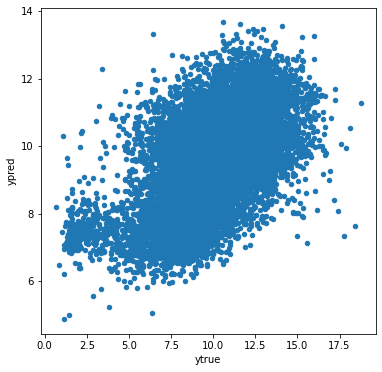

In [38]:
print(r2_score(df_eval2['ytrue'], df_eval2['ypred']))
df_eval2.plot.scatter('ytrue', 'ypred', figsize=(6, 6));

In [39]:
df_eval2.to_csv('../output/oof_kronecker_epi_DD.csv', index=False)

In [40]:
!ls -lh ../output/oof_kronecker*

-rw-r--r-- 1 igorf samuelbf 839K Jan 31 19:25 ../output/oof_kronecker_additive.csv
-rw-r--r-- 1 igorf samuelbf 838K Jan 31 22:25 ../output/oof_kronecker_dominant.csv
-rw-r--r-- 1 igorf samuelbf 839K Feb  1 15:47 ../output/oof_kronecker_epi_AA.csv
-rw-r--r-- 1 igorf samuelbf 837K Feb  1 18:17 ../output/oof_kronecker_epi_DD.csv
